In [42]:
import cv2
import numpy as np
import pandas as pd
import random
import os
from matplotlib import pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from tqdm import tqdm
import json

from pprint import pprint

import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
def cv2_imshow(image, figsize=(10, 8)):
    """
    Display an image with Matplotlib, hardcoding the plot size.
    
    Args:
        image (ndarray): The image to display (BGR or grayscale).
        figsize (tuple): Tuple (width, height) for the plot size in inches.
    """
    # Check if the image is in BGR format and convert to RGB for proper display
    if len(image.shape) == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif len(image.shape) == 2:  # Grayscale image
        plt.gray()  # Set color map to gray for grayscale images

    # Display the image with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis for better display
    plt.show()

In [44]:
def attempt_to_find_image_path(possible_dirs, file_name, image=True):
  # Strip extension from file_name
  file_name = file_name.split('.')[0]
  # Look for the base name + image extensions
  for directory in possible_dirs:
    for ext in ['jpg', 'jpeg', 'png']:
      if image:
        file_path = f"{directory}/{file_name}.{ext}"
        if os.path.exists(file_path):
          return file_path
  # Throw error if not found
  raise FileNotFoundError(f"File {file_name} not found in any of the directories.")

In [45]:
def attempt_to_draw_from_df(input_df, file_name, possible_image_dirs, keypoints_mask, extra_keypoints_mask = None, figsize = (8, 6), font_scale = None, font_thickness = None, point_size = None):
  hands_from_the_file_rows = input_df[input_df['FILE_NAME'] == file_name]


  greens_list = [(i*255/5, 255, i*255/5) for i in range(3)]
  blues_list = [(255, i*255/5, i*255/5) for i in range(3)]
  reds_list = [(i*255/5, i*255/5, 255) for i in range(3)]
  
  # Attempt to find image path
  relative_img_path = attempt_to_find_image_path(possible_image_dirs, file_name)
  hands_from_the_file_rows.reset_index(drop=True, inplace=True)
  
  # Load image
  img = cv2.imread(relative_img_path)
  img_height = img.shape[0]
  img_width = img.shape[1]
  

  for i, row in hands_from_the_file_rows.iterrows():
    # If there is a bounding box column, draw the bounding box
    if "BB_CX" in hands_from_the_file_rows.columns:
      bb_cx = row["BB_CX"]
      bb_cy = row["BB_CY"]
      bb_w = row["BB_W"]
      bb_h = row["BB_H"]
      if font_scale is None:
        font_scale = max(2, 5*np.sqrt(bb_w*bb_h*img_width*img_height)/(800))
      if font_thickness is None:
        font_thickness = max(2, int(100*np.sqrt(bb_w*bb_h*img_width*img_height)/(3800)))
        white_thickness = max(2, int(font_thickness*0.75))
      if point_size is None:
        point_size = int(90*np.sqrt(bb_w*bb_h*img_width*img_height)/(4000))
        white_point_size_inside = int(point_size*0.5)
      
      x = int((bb_cx - bb_w / 2) * img_width)
      y = int((bb_cy - bb_h / 2) * img_height)
      w = int(bb_w * img_width)
      h = int(bb_h * img_height)
      cv2.rectangle(img, (x, y), (x + w, y + h), greens_list[i], 2)
    
    # Draw keypoints
    for kp_index, kp in enumerate(keypoints_mask):
      x = int(row[f"{kp}_x"] * img_width)
      y = int(row[f"{kp}_y"] * img_height)
      if kp_index ==0:
        # Draw the handedness if it exists
        if "HANDEDNESS" in hands_from_the_file_rows.columns:
          handedness = row["HANDEDNESS"]
          handedness_text = "Right" if handedness == 1 else "Left"
          # Draw text
          cv2.putText(img, handedness_text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, int(font_scale*0.8), (0, 0, 0), font_thickness)
          # Draw white inline
          cv2.putText(img, handedness_text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, int(font_scale*0.8), (255, 255, 255), white_thickness)
      # Draw text of index
      cv2.putText(img, str(kp_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (0, 0, 0), font_thickness//2)
      # Draw white inline
      cv2.putText(img, str(kp_index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (255, 255, 255), white_thickness//2)
      cv2.circle(img, (x, y), point_size, reds_list[i], -1)
      cv2.circle(img, (x, y), white_point_size_inside, (255, 255, 255), -1)
    
    if extra_keypoints_mask is not None:
      for kp_index, kp in enumerate(extra_keypoints_mask):
        x = int(row[f"{kp}_x"] * img_width)
        y = int(row[f"{kp}_y"] * img_height)
        cv2.circle(img, (x, y), point_size, blues_list[i], -1)
        cv2.circle(img, (x, y), white_point_size_inside, (255, 255, 255), -1)
        cv2.putText(img, kp, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (0, 0, 0), font_thickness//2)
        cv2.putText(img, kp, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale//2, (255, 255, 255), white_thickness//2)

  # Display the image
  plt.figure(figsize=figsize)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()


In [46]:
def make_hand_keypoint_label_files(path_to_image_dir: str, detector, path_to_output_dir):
    # Get all the image files
    img_files = [file_name for file_name in os.listdir(path_to_image_dir) if file_name.endswith(".jpg")]    

    for file_name in tqdm(img_files, desc = "Processing images"):
        current_img = mp.Image.create_from_file(os.path.join(path_to_image_dir, file_name))
        result = detector.detect(current_img)
        # Prepare into a form to save
        list_of_hand_dicts = []
        
        hand_landmarks_list = result.hand_landmarks
        handedness_list = result.handedness

        for idx in range(len(hand_landmarks_list)):
            hand_dict = {}
            normalised_keypoints = hand_landmarks_list[idx]
            hand_dict["handedness"] = 0 if handedness_list[idx][0].category_name == "Left" else 1
            hand_dict["keypoints"] = []
            for landmark in normalised_keypoints:
                # Because the model always returns 0 for presence and visibility, we set visibility to 1 if it is in bounds of the image and 0 if it is not
                # https://github.com/google-ai-edge/mediapipe/issues/5212
                true_visibility = 1 if 0 <= landmark.x <= 1 and 0 <= landmark.y <= 1 else 0
                hand_dict["keypoints"].append({"x": landmark.x, "y": landmark.y, "z": landmark.z, "visibility": true_visibility})
            list_of_hand_dicts.append(hand_dict)
        with open(os.path.join(path_to_output_dir, file_name.replace(".jpg", ".json")), "w") as f:
            json.dump(list_of_hand_dicts, f)
    return

In [47]:
def parse_yolo_compatible_string(data_string):
    # Split the string into individual values
    values = list(map(float, data_string.split()))
    
    # Extract the class ID
    class_id = int(values[0])
    
    # Extract the bounding box parameters
    bbox = values[1:5]
    
    # Extract the keypoints (21 tuples of (norm_x, norm_y, visible))
    keypoints = []
    for i in range(5, len(values), 3):
        keypoints.append((values[i], values[i + 1], int(values[i + 2])))
    
    # Return the parsed data
    return class_id, bbox, keypoints

def load_df_yolo_labels_from_dir(path_to_yolo_labels):
    def create_dataframe_row(file_name, bb_params, keypoints):
        # Prepare the bounding box parameters
        bb_x, bb_y, bb_w, bb_h = bb_params

        # Prepare the list of keypoints
        keypoint_dict = {}
        keypoint_names = [
            "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
            "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
            "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
            "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
            "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
            "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
        ]

        # Add keypoints to the dictionary
        for i, (x, y, visibility) in enumerate(keypoints):
            if visibility == 0:
                keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
                keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
            else:
                keypoint_dict[f"{keypoint_names[i]}_x"] = x
                keypoint_dict[f"{keypoint_names[i]}_y"] = y

        # Construct the dataframe row
        row = {
            "FILE_NAME": file_name,
            "bb_x": bb_x,
            "bb_y": bb_y,
            "bb_w": bb_w,
            "bb_h": bb_h,
            **keypoint_dict
        }
        return row 

    list_of_rows = []

    directory = os.path.join(path_to_yolo_labels)
    # Iterate through each file in the directory
    for filename in tqdm(os.listdir(directory), desc = "Processing Ultralytics YOLO labels"):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            
            # Open and read each .txt file
            with open(file_path, 'r') as file:
                class_id, bbox, keypoints = parse_yolo_compatible_string(file.readline())
                list_of_rows.append(create_dataframe_row(filename, bbox, keypoints))
    return pd.DataFrame(list_of_rows)

In [48]:
def load_df_mp_hand_keypoints(json_dir: str, extra_point = False): 
# Returns a dataframe with flattened keypoints and additional data
    def create_dataframe_row(file_name, keypoints, hand_id, handedness, extra_point_coords = None):    
        # RETURNS A DICTIONARY OF KEYPOINTS
        # Prepare the list of keypoints
        keypoint_dict = {}
        keypoint_names = [
            "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
            "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
            "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
            "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
            "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
            "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
        ]
        
        # Add keypoints to the dictionary
        for i, kp in enumerate(keypoints):
            if kp['visibility'] == 0:
                keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
                keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
            else:
                keypoint_dict[f"{keypoint_names[i]}_x"] = kp['x']
                keypoint_dict[f"{keypoint_names[i]}_y"] = kp['y']
        
        # Add the extra point if it exists
        if extra_point_coords:
            keypoint_dict["HYPOTHENAR_x"] = extra_point_coords["x"]
            keypoint_dict["HYPOTHENAR_y"] = extra_point_coords["y"]

        # Construct the dataframe row
        row = {
            "FILE_NAME": file_name,
            "HAND_ID": hand_id,
            "HANDEDNESS": handedness,
            **keypoint_dict
        }
        return row 

    list_of_rows = []
    for file_name in tqdm(os.listdir(json_dir), desc = "Loading JSON files"):
        with open(os.path.join(json_dir, file_name), "r") as f:
            hands = json.load(f)
            for i in range(len(hands)):
                if extra_point:
                    list_of_rows.append(create_dataframe_row(file_name, hands[i]["keypoints"], hand_id= i, handedness=hands[i]["handedness"], extra_point_coords = hands[i]["extra_point"]))
                else:
                    list_of_rows.append(create_dataframe_row(file_name, hands[i]["keypoints"], hand_id= i, handedness=hands[i]["handedness"]))
    return pd.DataFrame(list_of_rows)


In [49]:
def hagrid_bbox_to_yolo_bbox(bbox):
  """
  Given the bbox in Hagrid format, this function will return the bbox in YOLO format.
  """
  x, y, w, h = bbox

  return [x+w/2, y+h/2, w, h]

def load_hagrid(path_to_json_file):
  """
  Given the path to the json file and the path to the images, this function will return the data in the format:
  {
    "uuid": {
      "bbox": [x, y, w, h],
      "keypoints": [[x, y, v], ...]

  """
  with open(path_to_json_file) as f:
    data = json.load(f)
  
  list_of_rows = []
  for uuid, value in data.items():
    if len(value['hand_landmarks']) != 1:
      continue
    bbox = value['bboxes'][0]
    yolo_bbox = hagrid_bbox_to_yolo_bbox(bbox)
    keypoints = value['hand_landmarks'][0]
    keypoint_dict = {}
    keypoint_names = [
        "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", 
        "INDEX_FINGER_MCP", "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", 
        "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", "MIDDLE_FINGER_PIP", 
        "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
        "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", 
        "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP"
    ]

    # Add keypoints to the dictionary
    for i, (x, y) in enumerate(keypoints):
        # if visibility == 0:
        #   keypoint_dict[f"{keypoint_names[i]}_x"] = np.nan
        #   keypoint_dict[f"{keypoint_names[i]}_y"] = np.nan
        # else:
      keypoint_dict[f"{keypoint_names[i]}_x"] = x
      keypoint_dict[f"{keypoint_names[i]}_y"] = y

    row = {
        "FILE_NAME": uuid,
        "BB_CX": yolo_bbox[0],
        "BB_CY": yolo_bbox[1],
        "BB_W": yolo_bbox[2],
        "BB_H": yolo_bbox[3],
        **keypoint_dict
    }
    list_of_rows.append(row)
  return pd.DataFrame(list_of_rows)


In [50]:
def get_cummulative_spatial_error(df1, df2, hand_keypoints):
    # Return a series of errors (sums of euclidean distances between keypoints)
    # Calculate the sum of the euclidean distances between the keypoints as a measure of error
    def get_error(row1, row2):
        error = 0
        for kp in hand_keypoints:
            x1 = row1[f"{kp}_x"]
            y1 = row1[f"{kp}_y"]
            x2 = row2[f"{kp}_x"]
            y2 = row2[f"{kp}_y"]
            error += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        return error
    
    errors = []
    for i in range(len(df1)):
        errors.append(get_error(df1.iloc[i], df2.iloc[i]))
    return errors

def get_mean_cummulative_spatial_error(df1, df2, hand_keypoints):
    # Calculate the sum of the euclidean distances between the keypoints as a measure of error
    # Average of cumulative euclidean distances
    def get_error(row1, row2):
        error = 0
        for kp in hand_keypoints:
            x1 = row1[f"{kp}_x"]
            y1 = row1[f"{kp}_y"]
            x2 = row2[f"{kp}_x"]
            y2 = row2[f"{kp}_y"]
            error += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        return error
    
    errors = []
    for i in range(len(df1)):
        errors.append(get_error(df1.iloc[i], df2.iloc[i]))
    return np.mean(errors)

def average_middle_finger(df):
    # Calculate the average distance from MIDDLE_FINGER_MCP to MIDDLE_FINGER_TIP
    errors = []
    for i in range(len(df)):
        x1 = df.iloc[i]["MIDDLE_FINGER_MCP_x"]
        y1 = df.iloc[i]["MIDDLE_FINGER_MCP_y"]
        x2 = df.iloc[i]["MIDDLE_FINGER_TIP_x"]
        y2 = df.iloc[i]["MIDDLE_FINGER_TIP_y"]
        errors.append(np.sqrt((x1 - x2)**2 + (y1 - y2)**2))
    return np.mean(errors)

In [51]:
def generate_df_bounding_boxes(df, keypoints_mask, padding=0.1):
    def get_bounding_box(row, padding):
        # Get the x and y coordinates of the keypoints
        x_coords = [row[f"{kp}_x"] for kp in keypoints_mask]
        y_coords = [row[f"{kp}_y"] for kp in keypoints_mask]

        # Calculate the bounding box parameters
        bb_x = min(x_coords)
        bb_y = min(y_coords)
        bb_w = max(x_coords) - bb_x
        bb_h = max(y_coords) - bb_y

        # Calculate center of the bounding box
        bb_cx = bb_x + bb_w / 2
        bb_cy = bb_y + bb_h / 2

        # Calculate maximum padding to keep the box within image boundaries
        max_padding_x = min(bb_cx - bb_w / 2, 1 - (bb_cx + bb_w / 2)) / (bb_w / 2)
        max_padding_y = min(bb_cy - bb_h / 2, 1 - (bb_cy + bb_h / 2)) / (bb_h / 2)
        max_padding = min(max_padding_x, max_padding_y)

        # Apply the smaller of the user-provided padding or max possible padding
        effective_padding = min(padding, max_padding)
        bb_w *= (1 + effective_padding)
        bb_h *= (1 + effective_padding)

        return bb_cx, bb_cy, bb_w, bb_h

    # Return DataFrame with the columns BB_CX, BB_CY, BB_W, BB_H
    return pd.DataFrame(
        [get_bounding_box(row, padding) for _, row in df.iterrows()],
        columns=["BB_CX", "BB_CY", "BB_W", "BB_H"]
    )

def img_to_bb_space_transform_df(df, keypoints_mask):
    def image_to_bounding_box_space(x_img, y_img, bb_center_x, bb_center_y, bb_width, bb_height):
        # Shift origin to bounding box center
        x_shifted = x_img - bb_center_x
        y_shifted = y_img - bb_center_y

        # Normalize by half the bounding box dimensions
        x_bb = x_shifted / (bb_width / 2)
        y_bb = y_shifted / (bb_height / 2)

        return x_bb, y_bb
    
    def image_to_bounding_box_space_row(row):
        # Get the bounding box parameters
        bb_cx = row["BB_CX"]
        bb_cy = row["BB_CY"]
        bb_w = row["BB_W"]
        bb_h = row["BB_H"]
        
        # Apply the transformation to each keypoint
        for kp in keypoints_mask:
            x_img = row[f"{kp}_x"]
            y_img = row[f"{kp}_y"]
            x_bb, y_bb = image_to_bounding_box_space(x_img, y_img, bb_cx, bb_cy, bb_w, bb_h)
            row[f"{kp}_x"] = x_bb
            row[f"{kp}_y"] = y_bb
        return row
    
    return df.apply(image_to_bounding_box_space_row, axis=1)

def bb_to_img_space_transform_df(df, keypoints_mask):
    def bounding_box_to_image_space(x_bb, y_bb, bb_center_x, bb_center_y, bb_width, bb_height):
        # Denormalize by half the bounding box dimensions
        x_shifted = x_bb * (bb_width / 2)
        y_shifted = y_bb * (bb_height / 2)
        
        # Shift origin back to the image space
        x_img = x_shifted + bb_center_x
        y_img = y_shifted + bb_center_y

        return x_img, y_img
    
    def bounding_box_to_image_space_row(row):
        # Get the bounding box parameters
        bb_cx = row["BB_CX"]
        bb_cy = row["BB_CY"]
        bb_w = row["BB_W"]
        bb_h = row["BB_H"]
        
        # Apply the transformation to each keypoint
        for kp in keypoints_mask:
            x_bb = row[f"{kp}_x"]
            y_bb = row[f"{kp}_y"]
            x_img, y_img = bounding_box_to_image_space(x_bb, y_bb, bb_cx, bb_cy, bb_w, bb_h)
            row[f"{kp}_x"] = x_img
            row[f"{kp}_y"] = y_img
        return row
    
    return df.apply(bounding_box_to_image_space_row, axis=1)

def calculate_rotation_angle_degrees(wrist_x, wrist_y, middle_finger_mcp_x, middle_finger_mcp_y):
    # Form the vector (WRIST -> MIDDLE_FINGER_MCP)
    vector_x = middle_finger_mcp_x - wrist_x
    vector_y = middle_finger_mcp_y - wrist_y

    # Normalize the vector
    magnitude = np.sqrt(vector_x**2 + vector_y**2)
    unit_vector_x = vector_x / magnitude
    unit_vector_y = vector_y / magnitude

    # Calculate the angle to align with (0,1) using dot product
    dot_product = unit_vector_y  # Since (0,1) has x=0
    angle_rad = np.arccos(dot_product)

    # Determine the sign of rotation using the cross product (to account for direction)
    cross_product = unit_vector_x
    if cross_product < 0:
        angle_rad = -angle_rad

    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def rotate_point(x, y, angle_rad):
    # Apply 2D rotation matrix
    rotated_x = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    rotated_y = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return rotated_x, rotated_y

def transform_to_rotated_bb_space(df, keypoints_mask, wrist_key, middle_finger_mcp_key):
    def rotate_bb_space_row(row):
        # Get the rotation angle in degrees
        wrist_x, wrist_y = row[f"{wrist_key}_x"], row[f"{wrist_key}_y"]
        middle_finger_x, middle_finger_y = row[f"{middle_finger_mcp_key}_x"], row[f"{middle_finger_mcp_key}_y"]
        angle_deg = calculate_rotation_angle_degrees(wrist_x, wrist_y, middle_finger_x, middle_finger_y)

        # Convert degrees to radians for rotation
        angle_rad = np.radians(angle_deg)

        # Rotate each keypoint
        for kp in keypoints_mask:
            x_bb = row[f"{kp}_x"]
            y_bb = row[f"{kp}_y"]
            rotated_x, rotated_y = rotate_point(x_bb, y_bb, angle_rad)
            row[f"{kp}_x"] = rotated_x
            row[f"{kp}_y"] = rotated_y

        # Add the rotation degree to the row
        row["ROT_DEG"] = angle_deg
        return row

    return df.apply(rotate_bb_space_row, axis=1)

def reverse_rotation_from_rotated_bb_space(df, keypoints_mask):
    def reverse_rotate_bb_space_row(row):
        # Get the rotation angle in degrees and convert to radians
        angle_deg = row["ROT_DEG"]
        angle_rad = np.radians(-angle_deg)  # Negate the angle for reverse rotation

        # Reverse rotate each keypoint
        for kp in keypoints_mask:
            x_rot = row[f"{kp}_x"]
            y_rot = row[f"{kp}_y"]
            original_x, original_y = rotate_point(x_rot, y_rot, angle_rad)
            row[f"{kp}_x"] = original_x
            row[f"{kp}_y"] = original_y

        return row

    return df.apply(reverse_rotate_bb_space_row, axis=1)

### Data Processing

In [52]:
hand_keypoints_names = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_FINGER_MCP",
    6: "INDEX_FINGER_PIP",
    7: "INDEX_FINGER_DIP",
    8: "INDEX_FINGER_TIP",
    9: "MIDDLE_FINGER_MCP",
    10: "MIDDLE_FINGER_PIP",
    11: "MIDDLE_FINGER_DIP",
    12: "MIDDLE_FINGER_TIP",
    13: "RING_FINGER_MCP",
    14: "RING_FINGER_PIP",
    15: "RING_FINGER_DIP",
    16: "RING_FINGER_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP"
}

flattened_keypoint_names = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() for axis in ["x", "y"]]

In [53]:
# Instantiate MEDIAPIPE DETECTOR MODEL
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')

single_hand_options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
two_hand_options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)

single_hand_detector = vision.HandLandmarker.create_from_options(single_hand_options)
two_hand_detector = vision.HandLandmarker.create_from_options(two_hand_options)


In [54]:
def calculate_mean_iou(df_detected, df_ground_truth):
    """
    Calculate the mean IoU (%) between detected and ground truth bounding boxes.

    Parameters:
        df_detected (pd.DataFrame): DataFrame with detected bounding boxes (BB_CX, BB_CY, BB_H, BB_W).
        df_ground_truth (pd.DataFrame): DataFrame with ground truth bounding boxes (BB_CX, BB_CY, BB_H, BB_W).

    Returns:
        float: Mean IoU in percentage.
    """
    def calculate_iou(row1, row2):
        # Extract coordinates and sizes
        x1_det, y1_det = row1['BB_CX'] - row1['BB_W'] / 2, row1['BB_CY'] - row1['BB_H'] / 2
        x2_det, y2_det = row1['BB_CX'] + row1['BB_W'] / 2, row1['BB_CY'] + row1['BB_H'] / 2
        
        x1_gt, y1_gt = row2['BB_CX'] - row2['BB_W'] / 2, row2['BB_CY'] - row2['BB_H'] / 2
        x2_gt, y2_gt = row2['BB_CX'] + row2['BB_W'] / 2, row2['BB_CY'] + row2['BB_H'] / 2
        
        # Calculate intersection coordinates
        x_left = max(x1_det, x1_gt)
        y_top = max(y1_det, y1_gt)
        x_right = min(x2_det, x2_gt)
        y_bottom = min(y2_det, y2_gt)
        
        # Check for non-overlapping boxes
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        # Calculate intersection and union areas
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        det_area = row1['BB_W'] * row1['BB_H']
        gt_area = row2['BB_W'] * row2['BB_H']
        union_area = det_area + gt_area - intersection_area
        
        # IoU calculation
        iou = intersection_area / union_area
        return iou

    # Apply the IoU function row-wise and calculate the mean IoU
    ious = [
        calculate_iou(df_detected.iloc[i], df_ground_truth.iloc[i]) 
        for i in range(len(df_detected))
    ]
    mean_iou = sum(ious) / len(ious) * 100  # Convert to percentage
    
    return mean_iou


In [55]:
def transform_to_normalized_space(df, hand_keypoints):
    df_bb_space = img_to_bb_space_transform_df(df, hand_keypoints)
    df_rotated = transform_to_rotated_bb_space(df_bb_space, hand_keypoints, wrist_key="WRIST", middle_finger_mcp_key="MIDDLE_FINGER_MCP")
    return df_rotated

def transform_to_image_space(df, hand_keypoints):
    # Reverse the transformations
    df_rotated = reverse_rotation_from_rotated_bb_space(df, hand_keypoints)
    df_img_space = bb_to_img_space_transform_df(df_rotated, hand_keypoints)

    return df_img_space

In [56]:
def process_strings(strings):
    return list({s[:-2] for s in strings if s.endswith('_x') or s.endswith('_y')})

def add_bounding_box_columns(df, keypoints_mask):
    if 'BB_CX' in df.columns:
        return df
    # Generate BBOX for our annotations
    df_bounding_boxes = generate_df_bounding_boxes(df, keypoints_mask)
    df_bounding_boxes.index = df.index
    df = pd.concat([df, df_bounding_boxes], axis=1)
    return df

In [57]:
seed = 7

hand_keypoints_no_pinky_MCP = [kp for kp in hand_keypoints_names.values() if "PINKY_MCP" != kp]
flattened_hand_keypoints_no_pinky_MCP = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() if "PINKY_MCP" != v for axis in ["x", "y"]]

# hand keypoints no THUMB_CMC
hand_keypoints_no_thumb_CMC = [kp for kp in hand_keypoints_names.values() if "THUMB_CMC" != kp]
flattened_hand_keypoints_no_thumb_CMC = [f"{v}_{axis}" for k, v in hand_keypoints_names.items() if "THUMB_CMC" != v for axis in ["x", "y"]]

In [58]:
# FIRST HAGRID DATASET
# This is palm fingers apart
hagrid_palm_train_df = load_hagrid('hagrid/data/annotations/train/palm.json')
hagrid_palm_val_df = load_hagrid('hagrid/data/annotations/val/palm.json')
hagrid_palm_test_df = load_hagrid('hagrid/data/annotations/test/palm.json')

# This is palm fingers together
hagrid_stop_train_df = load_hagrid('hagrid/data/annotations/train/stop.json')
hagrid_stop_val_df = load_hagrid('hagrid/data/annotations/val/stop.json')
hagrid_stop_test_df = load_hagrid('hagrid/data/annotations/test/stop.json')

# This is dorsal fingers together
hagrid_stopinv_train_df = load_hagrid('hagrid/data/annotations/train/stop_inverted.json')
hagrid_stopinv_val_df = load_hagrid('hagrid/data/annotations/val/stop_inverted.json')
hagrid_stopinv_test_df = load_hagrid('hagrid/data/annotations/test/stop_inverted.json')

# SECOND is 11k HANDS dataset
# Palmar, dorsal fingers together and apart all in one
train_11k_df = load_df_yolo_labels_from_dir('hand-keypoints/train/labels')
val_11k_df = load_df_yolo_labels_from_dir('hand-keypoints/val/labels')

# DROP NA from all
hagrid_palm_train_df = hagrid_palm_train_df.dropna()
hagrid_palm_val_df = hagrid_palm_val_df.dropna()
hagrid_palm_test_df = hagrid_palm_test_df.dropna()
hagrid_stop_train_df = hagrid_stop_train_df.dropna()
hagrid_stop_val_df = hagrid_stop_val_df.dropna()
hagrid_stop_test_df = hagrid_stop_test_df.dropna()
hagrid_stopinv_train_df = hagrid_stopinv_train_df.dropna()
hagrid_stopinv_val_df = hagrid_stopinv_val_df.dropna()
hagrid_stopinv_test_df = hagrid_stopinv_test_df.dropna()
train_11k_df = train_11k_df.dropna()
val_11k_df = val_11k_df.dropna()

# Train test split train

train_11k_df, test_11k_df = train_test_split(train_11k_df, test_size=0.2, shuffle=False)


# Print the length of each dataframe
print("Hagrid Palm Train:", len(hagrid_palm_train_df))
print("Hagrid Palm Val:", len(hagrid_palm_val_df))
print("Hagrid Palm Test:", len(hagrid_palm_test_df))
print("Hagrid Stop Train:", len(hagrid_stop_train_df))
print("Hagrid Stop Val:", len(hagrid_stop_val_df))
print("Hagrid Stop Test:", len(hagrid_stop_test_df))
print("Hagrid Stopinv Train:", len(hagrid_stopinv_train_df))
print("Hagrid Stopinv Val:", len(hagrid_stopinv_val_df))
print("Hagrid Stopinv Test:", len(hagrid_stopinv_test_df))
print("11k Train:", len(train_11k_df))
print("11k Val:", len(val_11k_df))
print("11k Test:", len(test_11k_df))



Processing Ultralytics YOLO labels: 100%|██████████| 3125/3125 [00:00<00:00, 18382.42it/s]


Hagrid Palm Train: 18536
Hagrid Palm Val: 2294
Hagrid Palm Test: 3974
Hagrid Stop Train: 18224
Hagrid Stop Val: 2234
Hagrid Stop Test: 3953
Hagrid Stopinv Train: 17364
Hagrid Stopinv Val: 2406
Hagrid Stopinv Test: 4007
11k Train: 3713
11k Val: 1991
11k Test: 929


In [59]:
# Load our_hands dataset
our_hands_rgb_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_RGB', extra_point=True)
our_hands_ir_df = load_df_mp_hand_keypoints('our_hands_dataset/LABELS_IR', extra_point=True)
our_hands_total = pd.concat([our_hands_rgb_df, our_hands_ir_df])

# Generate bounding boxes
our_hands_total_bounding_boxes_df = generate_df_bounding_boxes(our_hands_total, keypoints_mask = hand_keypoints_names.values())
# Add the columns to the dataframe
our_hands_total_bounding_boxes_df.index = our_hands_total.index
our_hands_total = pd.concat([our_hands_total, our_hands_total_bounding_boxes_df], axis=1)

Loading JSON files: 100%|██████████| 80/80 [00:00<00:00, 7999.82it/s]


In [60]:
# Rename yolo bbox columns to match my naming convention
train_11k_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)
val_11k_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)
test_11k_df.rename(columns={'bb_x': 'BB_CX', 'bb_y': 'BB_CY', 'bb_w': 'BB_W', 'bb_h': 'BB_H'}, inplace=True)

# MAKE BIG DATASET

In [61]:

size_of_clean_11k = int(len(train_11k_df)*1.66)
# combined_train_df = pd.concat([train_11k_df, 
#                               hagrid_palm_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0), 
#                               hagrid_stop_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0), 
#                               hagrid_stopinv_train_df.sample(n=size_of_clean_11k, random_state=seed, axis=0)])

combined_train_df = pd.concat([train_11k_df,
                                hagrid_palm_train_df, 
                                hagrid_stop_train_df, 
                                hagrid_stopinv_train_df])

combined_val_df = pd.concat([val_11k_df,
                                hagrid_palm_val_df, 
                                hagrid_stop_val_df, 
                                hagrid_stopinv_val_df])

combined_test_df = pd.concat([test_11k_df,
                                hagrid_palm_test_df, 
                                hagrid_stop_test_df, 
                                hagrid_stopinv_test_df])




In [62]:
# Print length of combined_train_df and combined_test_df
print("Combined Train:", len(combined_train_df))
print("Combined Test:", len(combined_test_df))
print("Combined Val:", len(combined_val_df))

Combined Train: 57837
Combined Test: 12863
Combined Val: 8925


In [63]:
# Reset index
combined_test_df.reset_index(drop=True, inplace=True)
combined_train_df.reset_index(drop=True, inplace=True)
combined_val_df.reset_index(drop=True, inplace=True)
# Transform to rotated bb space
combined_train_df_normalized = transform_to_normalized_space(combined_train_df, hand_keypoints_names.values())
combined_test_df_normalized = transform_to_normalized_space(combined_test_df, hand_keypoints_names.values())
combined_val_df_normalized = transform_to_normalized_space(combined_val_df, hand_keypoints_names.values())
# do the same for our dataset
our_hands_total.reset_index(drop=True, inplace=True)
our_hands_total_normalized_df = transform_to_normalized_space(our_hands_total, list(hand_keypoints_names.values()) + ["HYPOTHENAR"])
# Do it for hagrid classes so i can have separate tests for one class of gesture
hagrid_palm_test_df.reset_index(drop=True, inplace=True)
hagrid_palm_test_df_normalized = transform_to_normalized_space(hagrid_palm_test_df, hand_keypoints_names.values())
hagrid_stop_test_df.reset_index(drop=True, inplace=True)
hagrid_stop_test_df_normalized = transform_to_normalized_space(hagrid_stop_test_df, hand_keypoints_names.values())
hagrid_stopinv_test_df.reset_index(drop=True, inplace=True)
hagrid_stopinv_test_df_normalized = transform_to_normalized_space(hagrid_stopinv_test_df, hand_keypoints_names.values())

In [64]:
X_custom_eval = our_hands_total_normalized_df[flattened_hand_keypoints_no_thumb_CMC]
y_custom_eval = our_hands_total_normalized_df[['THUMB_CMC_x', 'THUMB_CMC_y']]

X_train = combined_train_df_normalized[flattened_hand_keypoints_no_thumb_CMC]
y_train = combined_train_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]
X_val = combined_val_df[flattened_hand_keypoints_no_thumb_CMC]
y_val = combined_val_df[['THUMB_CMC_x', 'THUMB_CMC_y']]
X_test = combined_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC]
y_test = combined_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]

# Additional test sets
# {"name": (X, y)}
additional_tests = {
  "HagridPalm": (hagrid_palm_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_palm_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]),
  "HagridStop": (hagrid_stop_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_stop_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']]),
  "HagridStopInv": (hagrid_stopinv_test_df_normalized[flattened_hand_keypoints_no_thumb_CMC], hagrid_stopinv_test_df_normalized[['THUMB_CMC_x', 'THUMB_CMC_y']])
}

In [66]:
from sklearn.model_selection import KFold
njobs = 14
X_train_tuning = X_train.sample(frac=0.33, random_state=seed)
y_train_tuning = y_train.loc[X_train_tuning.index]

number_of_folds = 3
kf = KFold(n_splits=number_of_folds, shuffle=False)

In [71]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

if tf.config.list_physical_devices('GPU'):
  # Try a simple GPU operation
  with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[1, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3, 1], name='b')
    c = tf.matmul(a, b)
    print(c)

Num GPUs Available:  0
[]
False


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from scikeras.wrappers import KerasRegressor  # Import from scikeras

input_shape = X_train.shape[1]
output_dim = y_train.shape[1]


# **Utilize All Computing Power**
# 1. Multi-threading/Multi-processing
#    -  Set `njobs` in `BayesSearchCV` appropriately (already in your provided code).
#    -  TensorFlow automatically uses multiple cores for many operations.
# 2. GPU Acceleration (if available)
gpus = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Define the model creation function for KerasRegressor
def create_model(
    learning_rate, num_hidden_layers, num_neurons, activation, dropout_rate
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))

    for _ in range(num_hidden_layers):
        model.add(layers.Dense(num_neurons, activation=activation))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(output_dim))  # Output layer for x and y coordinates

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model


# Wrap the Keras model with a function compatible with BayesSearchCV
def get_keras_model(
    learning_rate, num_hidden_layers, num_neurons, activation, dropout_rate
):
    # Clear any previous session to avoid conflicts
    tf.keras.backend.clear_session()
    return create_model(
        learning_rate, num_hidden_layers, num_neurons, activation, dropout_rate
    )


# Define the hyperparameter search space
search_space = {
    "learning_rate": Real(1e-5, 1e-2, prior="log-uniform"),
    "num_hidden_layers": Integer(1, 5),
    "num_neurons": Integer(30, 512),
    "activation": Categorical(["relu", "tanh", "sigmoid"]),
    "dropout_rate": Real(0.0, 0.5),
    "batch_size": Integer(16, 256),  # Add batch size to the search space
    "epochs": Integer(50, 200),  # Add epochs to the search space
}

# Create a KerasRegressor wrapper using scikeras
keras_regressor = KerasRegressor(model=get_keras_model, verbose=0, activation="relu")

# Create BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=keras_regressor,
    search_spaces=search_space,
    n_iter=50,  # Number of hyperparameter combinations to try
    cv=kf,
    n_jobs=njobs,
    verbose=2,
    random_state=seed,
    scoring="neg_mean_squared_error",  # Specify the scoring metric
)


# Perform hyperparameter tuning
bayes_search.fit(X_train_tuning, y_train_tuning)

# Train the best model on the full training set
best_model = bayes_search.best_estimator_.model
best_model.fit(
    X_train,
    y_train,
    epochs=bayes_search.best_params_["epochs"],
    batch_size=bayes_search.best_params_["batch_size"],
    verbose=2,
    validation_data=(X_val, y_val),
)

# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Now you can use best_model for predictions
# predictions = best_model.predict(X_new)

Num GPUs Available:  []
Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: Invalid parameter activation for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(activation=sigmoid)`
Check the list of available parameters with `estimator.get_params().keys()`

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
def tryGPR(X_train, y_train, X_test, y_test):
  X_te = X_test.copy()
  y_te = y_test.copy()
  X_tr = X_train.copy()
  y_tr = y_train.copy()
  # Subsample randomly training data to 10% size
  X_tr = X_tr.sample(frac=0.03, random_state=seed)
  y_tr = y_tr.loc[X_tr.index]

  # Print length of trianing data
  print("Length of training data:", len(X_tr))
  # Define the kernel (using RBF as an example)
  kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

  # Initialize the Gaussian Process Regressor
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

  # Fit the model to the training data
  gp.fit(X_tr, y_tr)
  # Make predictions
  y_pred, sigma = gp.predict(X_te, return_std=True)

  # Calculate R-squared value
  r2 = gp.score(X_te, y_te)
  print(f"R-squared: {r2:.4f}")
  print(sigma)

  # Calculate prediction errors
  errors = y_pred - y_te.values

  # Plot prediction errors
  plt.scatter(errors[:, 0], errors[:, 1])
  plt.xlabel("X Error")
  plt.ylabel("Y Error")
  plt.title("Prediction Errors")
  plt.show()

# Run
# tryGPR(X_train, y_train, X_test, y_test)

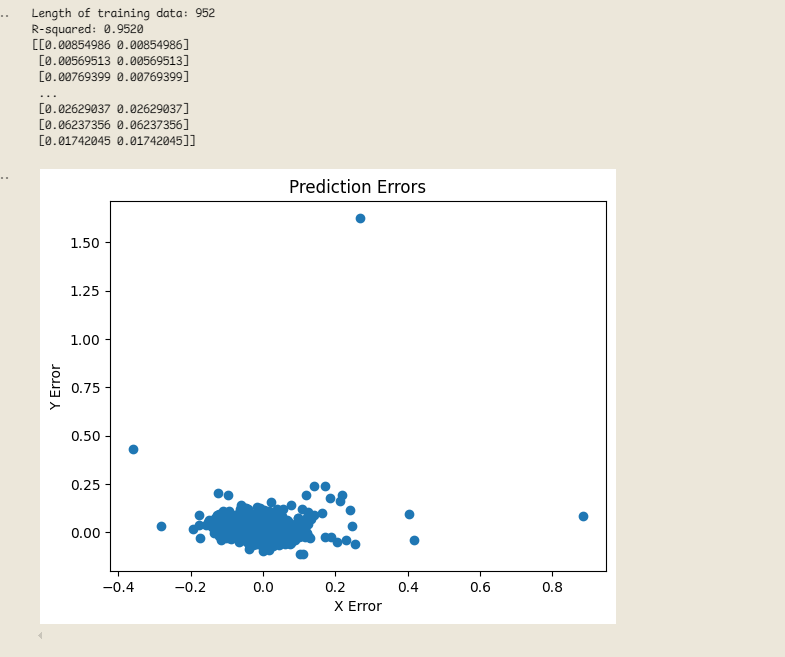

In [118]:
from sklearn.ensemble import RandomForestRegressor

from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

rf_model = RandomForestRegressor(random_state=seed, n_jobs=njobs)

param_space = {
    'n_estimators': Integer(50, 750),          # Number of trees
    'max_depth': Integer(5, 50),               # Depth of each tree
    'min_samples_split': Integer(2, 10),       # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),        # Minimum samples at a leaf node
    'max_features': Real(0.1, 1.0, prior='uniform')    # Features to consider
}

rf_opt = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    n_iter=50,                 # Number of iterations for optimization
    cv=kf,                     # K-Fold Cross Validation
    scoring='r2',              # Metric to optimize
    random_state=seed,
    n_jobs=njobs                  # Use all available cores
)

In [119]:
# if file exists
if os.path.isfile('output/rf_bayes_opt.pkl'):
  # load
  with open('output/rf_bayes_opt.pkl', 'rb') as f:
    rf_opt = pickle.load(f)
else:
  rf_opt.fit(X_train_tuning, y_train_tuning)

In [120]:
print("Best Parameters:", rf_opt.best_params_)
print("Best Validation Score:", rf_opt.best_score_)

# Evaluate on the validation set
val_score = rf_opt.best_estimator_.score(X_test, y_test)
print("Test Set Score:", val_score)

# Evaluate on the test set
test_score = rf_opt.best_estimator_.score(X_custom_eval, y_custom_eval)
print("Evaluation Set Score:", test_score)
if not os.path.isfile('output/rf_bayes_opt.pkl'):    
    with open('output/rf_bayes_opt.pkl', 'wb') as f:
        pickle.dump(rf_opt, f)

Best Parameters: OrderedDict({'max_depth': 50, 'max_features': 0.665508869053305, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
Best Validation Score: 0.9110527444522384
Test Set Score: 0.9686333521162195
Evaluation Set Score: 0.5515700097474805


`Best Parameters: OrderedDict({'max_depth': 27, 'max_features': 0.7230302205943789, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750})
Best Validation Score: 0.9955409082396779
Test Set Score: 0.9896417178652428
Evaluation Set Score: 0.8879499719441363`

In [121]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=seed, n_jobs=njobs)

# Define the hyperparameter search space
param_space = {
    'n_estimators': Integer(50, 750),             # Number of boosting rounds
    'max_depth': Integer(3, 20),                  # Maximum depth of trees
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Learning rate
    'min_child_weight': Integer(1, 10),           # Minimum sum of instance weight
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Subsample ratio for columns
    'gamma': Real(0.0, 5.0, prior='uniform')      # Minimum loss reduction
}

# Initialize BayesSearchCV
xgb_opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

In [122]:
if os.path.isfile('output/xgb_bayes_opt.pkl'):
  # load
  with open('output/xgb_bayes_opt.pkl', 'rb') as f:
    xgb_opt = pickle.load(f)
else:
  xgb_opt.fit(X_train_tuning, y_train_tuning)

In [123]:
# Print best parameters and scores
print("Best Parameters:", xgb_opt.best_params_)
print("Best Validation Score:", xgb_opt.best_score_)

# Evaluate on the test set
test_score = r2_score(y_test, xgb_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, xgb_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/xgb_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/xgb_bayes_opt.pkl", "wb") as file:
        pickle.dump(xgb_opt, file)
        print("Optimization results saved to 'xgb_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 635, 'subsample': 1.0})
Best Validation Score: 0.9201242327690125
Test Set Score: 0.9774792194366455
Evaluation Set Score (Custom Data): 0.4899672567844391


In [124]:
# Initialize k-NN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=njobs)

# Define the hyperparameter search space
param_space = {
    'n_neighbors': Integer(2, 75),               # Number of neighbors
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': Integer(1, 3)                           # Power parameter for Minkowski (if metric='minkowski')
}

# Initialize BayesSearchCV
knn_opt = BayesSearchCV(
    estimator=knn_model,
    search_spaces=param_space,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

In [125]:
if os.path.isfile('output/knn_bayes_opt.pkl'):
  # load
  with open('output/knn_bayes_opt.pkl', 'rb') as f:
    knn_opt = pickle.load(f)
else:
  knn_opt.fit(X_train_tuning, y_train_tuning)

In [126]:
# Print best parameters and scores
print("Best Parameters:", knn_opt.best_params_)
print("Best Validation Score:", knn_opt.best_score_)

# Evaluate on the test set
test_score = r2_score(y_test, knn_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, knn_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/knn_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/knn_bayes_opt.pkl", "wb") as file:
        pickle.dump(knn_opt, file)
        print("Optimization results saved to 'knn_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'metric': 'minkowski', 'n_neighbors': 6, 'p': 2, 'weights': 'distance'})
Best Validation Score: 0.8715603631853083
Test Set Score: 0.9227070371592994
Evaluation Set Score (Custom Data): 0.42226015620957313


In [127]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define pipeline for scaling (Lasso requires feature scaling)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', Lasso(max_iter=10000, random_state=seed))  # Lasso regression
])

# Define hyperparameter search space
param_space = {
    'lasso__alpha': Real(1e-4, 1.0, prior='log-uniform')  # Regularization strength
}

lasso_opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=50,
    cv=kf,
    scoring='r2',
    random_state=42,
    n_jobs=njobs
)

In [128]:
if os.path.isfile('output/lasso_bayes_opt.pkl'):
    # load
    with open('output/lasso_bayes_opt.pkl', 'rb') as f:
        lasso_opt = pickle.load(f)
else:   
    lasso_opt.fit(X_train_tuning, y_train_tuning)
        

In [129]:
print("Best Parameters:", lasso_opt.best_params_)
print("Best Validation Score:", lasso_opt.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test, lasso_opt.best_estimator_.predict(X_test))
print("Test Set Score:", test_score)

# Evaluate on the custom dataset
test_score_custom = r2_score(y_custom_eval, lasso_opt.best_estimator_.predict(X_custom_eval))
print("Evaluation Set Score (Custom Data):", test_score_custom)

if not os.path.isfile('output/lasso_bayes_opt.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output/lasso_bayes_opt.pkl", "wb") as file:
        pickle.dump(lasso_opt, file)
        print("Optimization results saved to 'lasso_bayes_opt.pkl'.")

Best Parameters: OrderedDict({'lasso__alpha': 0.0001})
Best Validation Score: 0.9904060420267505
Test Set Score: 0.9877321088787052
Evaluation Set Score (Custom Data): 0.3401620205513514


### Next is the representation of a "Schemkes model" that serves as a baseline for the task.
#### It returns an interpolation of two points to predict PINKY_MCP namely WRIST and PINKY_PIP
Let's calculate that!

In [130]:
from sklearn.base import BaseEstimator, RegressorMixin

class SchemkesInterpolationModel(BaseEstimator, RegressorMixin):
    def __init__(self, train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC'):
        """
        Initialize the model with train and target column configurations.

        Parameters:
        - train_columns: List of column prefixes for the training features (default: ['WRIST', 'INDEX_FINGER_MCP'])
        - target_column: Column prefix for the target (default: 'THUMB_CMC')
        """
        self.train_columns = train_columns
        self.target_column = target_column
        self.vertical_ratio = None
        self.horizontal_ratio = None

    def fit(self, X, y):
        """
        Fit the model to compute the vertical and horizontal ratios.

        Parameters:
        - X: DataFrame with columns ['WRIST_x', 'WRIST_y', 'INDEX_FINGER_MCP_x', 'INDEX_FINGER_MCP_y']
        - y: DataFrame with columns ['THUMB_CMC_x', 'THUMB_CMC_y']
        """
        # Extract feature and target columns based on the prefixes
        wrist_x, wrist_y = f"{self.train_columns[0]}_x", f"{self.train_columns[0]}_y"
        index_x, index_y = f"{self.train_columns[1]}_x", f"{self.train_columns[1]}_y"
        thumb_x, thumb_y = f"{self.target_column}_x", f"{self.target_column}_y"

        # Calculate distances
        wrist_to_index_vertical = np.abs(X[wrist_y] - X[index_y])
        wrist_to_index_horizontal = np.abs(X[wrist_x] - X[index_x])

        wrist_to_thumb_vertical = np.abs(X[wrist_y] - y[thumb_y])
        wrist_to_thumb_horizontal = np.abs(X[wrist_x] - y[thumb_x])

        # Compute ratios
        if np.mean(wrist_to_index_vertical) == 0:
            self.vertical_ratio = 0
        else:
            self.vertical_ratio = np.mean(wrist_to_thumb_vertical) / np.mean(wrist_to_index_vertical)
        
        if np.mean(wrist_to_index_horizontal) == 0:
            self.horizontal_ratio = 0
        else:
            self.horizontal_ratio = np.mean(wrist_to_thumb_horizontal) / np.mean(wrist_to_index_horizontal)
        return self

    def predict(self, X):
        """
        Predict THUMB_CMC_x and THUMB_CMC_y coordinates.

        Parameters:
        - X: DataFrame with columns ['WRIST_x', 'WRIST_y', 'INDEX_FINGER_MCP_x', 'INDEX_FINGER_MCP_y']

        Returns:
        - np.array of shape (n_samples, 2) with predicted THUMB_CMC_x and THUMB_CMC_y.
        """
        if self.vertical_ratio is None or self.horizontal_ratio is None:
            raise ValueError("The model must be fitted before predicting.")

        # Extract feature columns based on the prefixes
        wrist_x, wrist_y = f"{self.train_columns[0]}_x", f"{self.train_columns[0]}_y"
        index_x, index_y = f"{self.train_columns[1]}_x", f"{self.train_columns[1]}_y"

        # Compute predictions
        predictions = pd.DataFrame(columns=[f"{self.target_column}_x", f"{self.target_column}_y"])
        predictions[f"{self.target_column}_x"] = (1 - self.horizontal_ratio) * X[wrist_x] + self.horizontal_ratio * X[index_x]
        predictions[f"{self.target_column}_y"] = (1 - self.vertical_ratio) * X[wrist_y] + self.vertical_ratio * X[index_y]


        return predictions.to_numpy()

In [131]:
schemkes_model = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model.fit(X_train, y_train)

SchemkesInterpolationModel()

In [132]:
# Schemkes on test set
schemkes_predictions = schemkes_model.predict(X_test)
schemkes_r2 = r2_score(y_test, schemkes_predictions)
print("Schemkes R-squared on Test Set:", schemkes_r2)

# Schemkes on custom evaluation set
schemkes_custom_predictions = schemkes_model.predict(X_custom_eval)
schemkes_custom_r2 = r2_score(y_custom_eval, schemkes_custom_predictions)
print("Schemkes R-squared on Custom Evaluation Set:", schemkes_custom_r2)

# Try schemkes model that uses middle finger mcp instead of index finger mcp
schemkes_model_middle = SchemkesInterpolationModel(train_columns=['WRIST', 'MIDDLE_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_middle.fit(X_train, y_train)

# Schemkes middle on test set
schemkes_predictions_middle = schemkes_model_middle.predict(X_test)
schemkes_r2_middle = r2_score(y_test, schemkes_predictions_middle)
print("Schemkes R-squared on Test Set (Middle Finger MCP):", schemkes_r2_middle)

# Schemkes middle on custom evaluation set
schemkes_custom_predictions_middle = schemkes_model_middle.predict(X_custom_eval)
schemkes_custom_r2_middle = r2_score(y_custom_eval, schemkes_custom_predictions_middle)
print("Schemkes R-squared on Custom Evaluation Set (Middle Finger MCP):", schemkes_custom_r2_middle)

# Try schemkes model that uses wrist and pinky mcp
schemkes_model_pinky = SchemkesInterpolationModel(train_columns=['WRIST', 'PINKY_MCP'], target_column='THUMB_CMC')
schemkes_model_pinky.fit(X_train, y_train)

# Schemkes pinky on test set
schemkes_predictions_pinky = schemkes_model_pinky.predict(X_test)
schemkes_r2_pinky = r2_score(y_test, schemkes_predictions_pinky)
print("Schemkes R-squared on Test Set (Pinky MCP):", schemkes_r2_pinky)

# Schemkes pinky on custom evaluation set
schemkes_custom_predictions_pinky = schemkes_model_pinky.predict(X_custom_eval)
schemkes_custom_r2_pinky = r2_score(y_custom_eval, schemkes_custom_predictions_pinky)
print("Schemkes R-squared on Custom Evaluation Set (Pinky MCP):", schemkes_custom_r2_pinky)

# Try schemkes model that uses wrist and thumb mcp
schemkes_model_thumb = SchemkesInterpolationModel(train_columns=['WRIST', 'THUMB_MCP'], target_column='THUMB_CMC')
schemkes_model_thumb.fit(X_train, y_train)

# Schemkes thumb on test set
schemkes_predictions_thumb = schemkes_model_thumb.predict(X_test)
schemkes_r2_thumb = r2_score(y_test, schemkes_predictions_thumb)
print("Schemkes R-squared on Test Set (Thumb MCP):", schemkes_r2_thumb)

# Schemkes thumb on custom evaluation set
schemkes_custom_predictions_thumb = schemkes_model_thumb.predict(X_custom_eval)
schemkes_custom_r2_thumb = r2_score(y_custom_eval, schemkes_custom_predictions_thumb)
print("Schemkes R-squared on Custom Evaluation Set (Thumb MCP):", schemkes_custom_r2_thumb)

# Try schemkes model that uses wrist and ring finger mcp
schemkes_model_ring = SchemkesInterpolationModel(train_columns=['WRIST', 'RING_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_ring.fit(X_train, y_train)

# Schemkes ring on test set
schemkes_predictions_ring = schemkes_model_ring.predict(X_test)
schemkes_r2_ring = r2_score(y_test, schemkes_predictions_ring)
print("Schemkes R-squared on Test Set (Ring MCP):", schemkes_r2_ring)

# Schemkes ring on custom evaluation set
schemkes_custom_predictions_ring = schemkes_model_ring.predict(X_custom_eval)
schemkes_custom_r2_ring = r2_score(y_custom_eval, schemkes_custom_predictions_ring)
print("Schemkes R-squared on Custom Evaluation Set (Ring MCP):", schemkes_custom_r2_ring)




Schemkes R-squared on Test Set: 0.7620746934037265
Schemkes R-squared on Custom Evaluation Set: -0.10955749129830311
Schemkes R-squared on Test Set (Middle Finger MCP): -84.00505743055416
Schemkes R-squared on Custom Evaluation Set (Middle Finger MCP): -1.79258201649593
Schemkes R-squared on Test Set (Pinky MCP): -1.7672998954551253
Schemkes R-squared on Custom Evaluation Set (Pinky MCP): -7.072235632002313
Schemkes R-squared on Test Set (Thumb MCP): 0.9437010081745312
Schemkes R-squared on Custom Evaluation Set (Thumb MCP): 0.4544202113900491
Schemkes R-squared on Test Set (Ring MCP): -1.675467842610617
Schemkes R-squared on Custom Evaluation Set (Ring MCP): -6.5667214647960455


### Pipeline

Get dataset -> make folds -> calculate for each model

In [133]:
def interleaving_subsample(df, sample_size):
    """
    Perform interleaving subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).

    Returns:
        pd.DataFrame: Interleaved subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    # Calculate the interleaving step
    step = len(df) / sample_size

    # Select rows based on interleaved indices
    indices = (np.arange(sample_size) * step).astype(int)
    return df.iloc[indices]

def first_n_subsample(df, sample_size):
    """
    Perform first-n subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).

    Returns:
        pd.DataFrame: First-n subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    return df.iloc[:sample_size]

def random_subsample(df, sample_size, random_state=42):
    """
    Perform random subsampling on a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        sample_size (int): Desired number of rows in the subsample. Must be <= len(df).
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Random subsample of the DataFrame.
    """
    if sample_size <= 0 or sample_size > len(df):
        raise ValueError("Sample size must be a positive integer and <= the number of rows in the DataFrame.")

    return df.sample(sample_size, random_state=random_state)

def calculate_euclidean_distances(set1, set2):
    """
    Calculate the Euclidean distance for each row between two sets of coordinates.

    Parameters:
        set1 (pd.DataFrame or np.ndarray): First set of coordinates (n, 2).
        set2 (pd.DataFrame or np.ndarray): Second set of coordinates (n, 2).

    Returns:
        np.ndarray: A numpy array of shape (n, 1) containing the Euclidean distances.
    """
    # Convert to numpy arrays if inputs are DataFrames
    if isinstance(set1, pd.DataFrame):
        set1 = set1.values
    if isinstance(set2, pd.DataFrame):
        set2 = set2.values

    # Ensure the inputs have the correct shape
    if set1.shape != set2.shape or set1.shape[1] != 2:
        raise ValueError("Both sets must have the shape (n, 2).")

    # Calculate Euclidean distances
    distances = np.sqrt(np.sum((set1 - set2) ** 2, axis=1))
    return distances.reshape(-1, 1)

def evaluation_pipeline(X_train, y_train, X_test, y_test ,X_eval, y_eval, models, model_names, training_sizes, additional_test_sets=None, output_dir='output', subsample="interleave"):
    """
    Evaluates all models and saves the results.

    Parameters:
        normed_X_df (pd.DataFrame): Normalized feature DataFrame.
        normed_y_df (pd.DataFrame): Normalized target DataFrame.
        X_eval (pd.DataFrame): Evaluation feature DataFrame.
        y_eval (pd.DataFrame): Evaluation target DataFrame.
        models (list): List of models to evaluate.
        model_names (list): List of model names.
        model_params (list): List of model parameters.
        additional_test_sets (dict): Dictionary of additional test sets. {"name": (X, y)}
        output_dir (str): Directory to save the results.
    """



    subsampling_methods = {
        "interleave": interleaving_subsample,
        "first_n": first_n_subsample,
        "random": random_subsample
    }

    total_results = {}
    # For every model add a dictionary 
    for model_name in model_names:
        total_results[model_name] = {
            'R2': [],
            'Test_Error': [],
            'Eval_Error': []
        }
        if additional_test_sets is not None:
            for test_name, (additional_test_X, additional_test_y) in additional_test_sets.items():
                total_results[model_name][f'{test_name}_Error'] = []

    training_sizes_copy = training_sizes.copy()
    # Append len(X_train) to the copy if not already 
    if len(X_train) not in training_sizes_copy:
        training_sizes_copy.append(len(X_train))
    # Sort
    training_sizes_copy.sort()

    for i in tqdm(range(len(training_sizes_copy)), desc="Iterations"):
        current_size = training_sizes_copy[i]
        if current_size <= 0 or current_size > len(X_train):
            break
        # print("Iteration:", i, "Training size:", int(current_size))
        X_subsampled = subsampling_methods[subsample](X_train, int(current_size))
        # Set the same rows for y
        y_subsampled = y_train.loc[X_subsampled.index]

        # Calculate the results for all models
        for m_index in tqdm(range(len(models)), desc="Models", leave=False):
            model_name = model_names[m_index]
            model = models[m_index]

            # Create dir for model_name if not exists
            if not os.path.exists(f'{output_dir}/{model_name}'):
                os.makedirs(f'{output_dir}/{model_name}')

            # Fit the model
            model.fit(X_subsampled, y_subsampled)

            # Pickle model
            with open(f'{output_dir}/{model_name}/{model_name}_{subsample}_{int(current_size)}.pkl', 'wb') as f:
                pickle.dump(model, f)

            # Calculate R2 score
            r2 = model.score(X_test, y_test)
            total_results[model_name]['R2'].append(r2)

            # Calculate the test error
            test_pred = model.predict(X_test)
            test_error = np.mean(calculate_euclidean_distances(y_test, test_pred))
            total_results[model_name]['Test_Error'].append(test_error)
            
            # Calculate the evaluation error
            eval_error = np.mean(calculate_euclidean_distances(y_eval, model.predict(X_eval)))
            total_results[model_name]['Eval_Error'].append(eval_error)
            if additional_test_sets is not None:
                # For additional test sets
                for test_name, (additional_test_X, additional_test_y) in additional_test_sets.items():
                    additional_test_error = np.mean(calculate_euclidean_distances(additional_test_y, model.predict(additional_test_X)))
                    total_results[model_name][f'{test_name}_Error'].append(additional_test_error)
                
    return total_results

In [134]:
schemkes_model = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')

tuned_models = [
    schemkes_model,
    rf_opt.best_estimator_,
    xgb_opt.best_estimator_,
    knn_opt.best_estimator_,
    lasso_opt.best_estimator_,
]

tuned_models_names = [
    'Schemkes',
    'RandomForest',
    'XGBoost',
    'KNN',
    'Lasso'
]

sizes = [int(1.33**(0.8*x)) for x in range(20, 45)] + [len(X_train)]
sizes.sort()

total_results = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes , additional_test_sets=additional_tests, output_dir='output')


Iterations: 100%|██████████| 26/26 [13:08<00:00, 30.31s/it] 


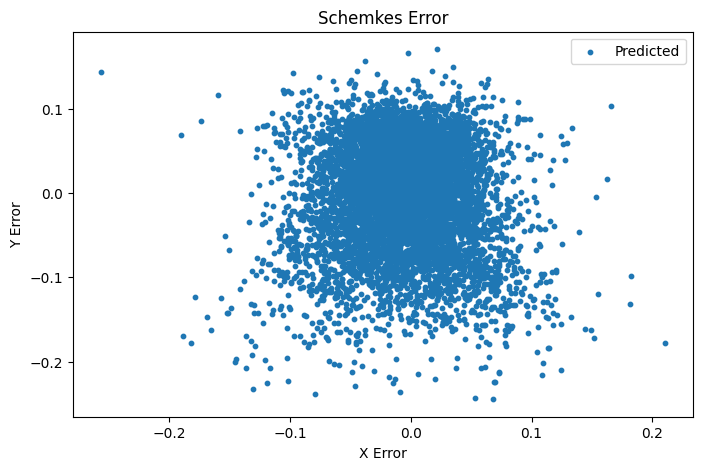

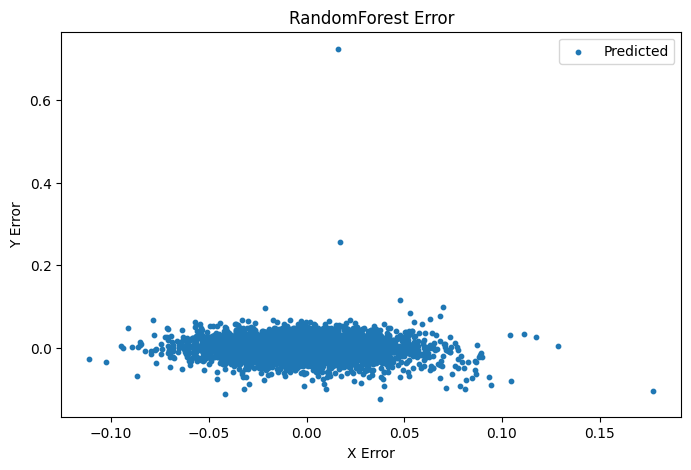

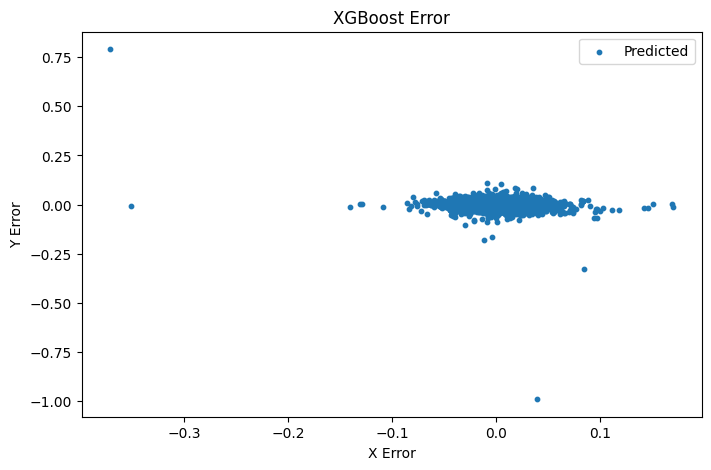

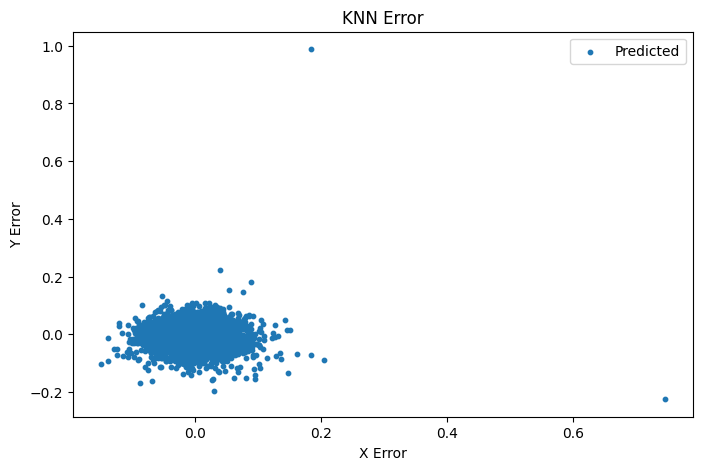

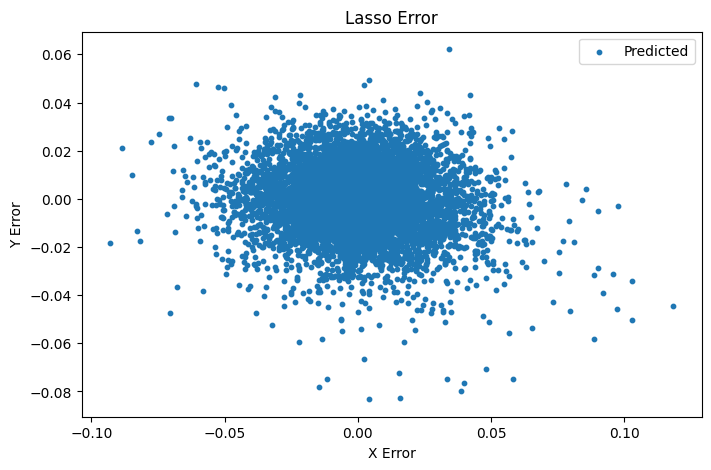

In [135]:
for i in range(len(tuned_models)):
    plt.figure(figsize=(8, 5))
    plt.scatter(tuned_models[i].predict(X_test)[:, 0] - y_test.to_numpy()[:, 0], tuned_models[i].predict(X_test)[:, 1] - y_test.to_numpy()[:, 1], label='Predicted', s=10)
    # plt.scatter(model.predict(X_custom_eval)[:, 0] - y_custom_eval[:, 0], model.predict(X_custom_eval)[:, 1] - y_custom_eval[:, 1], label='Evaluation', s=10)
    plt.xlabel('X Error')
    plt.ylabel('Y Error')
    plt.title(f'{tuned_models_names[i]} Error')
    plt.legend()   
    plt.show()
    


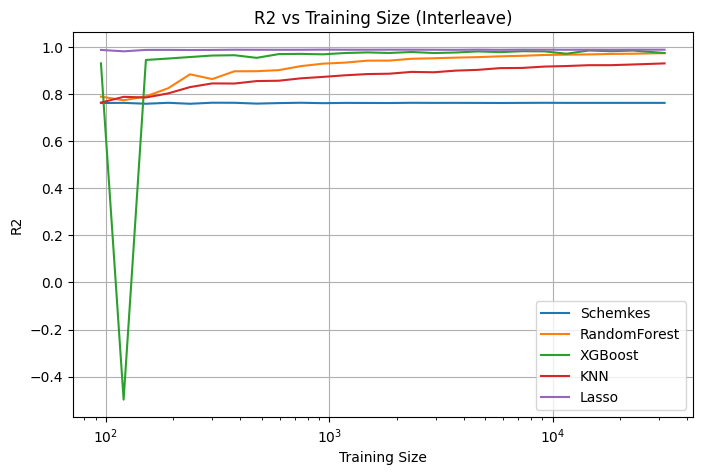

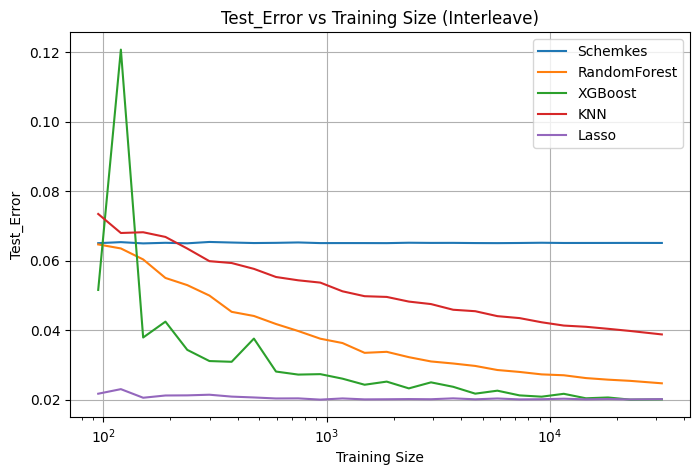

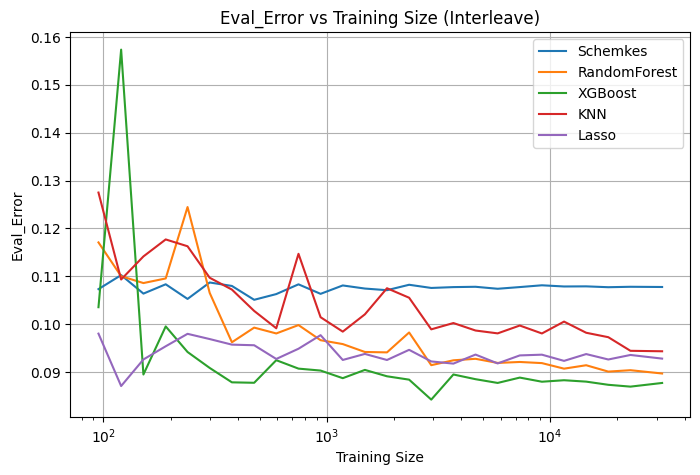

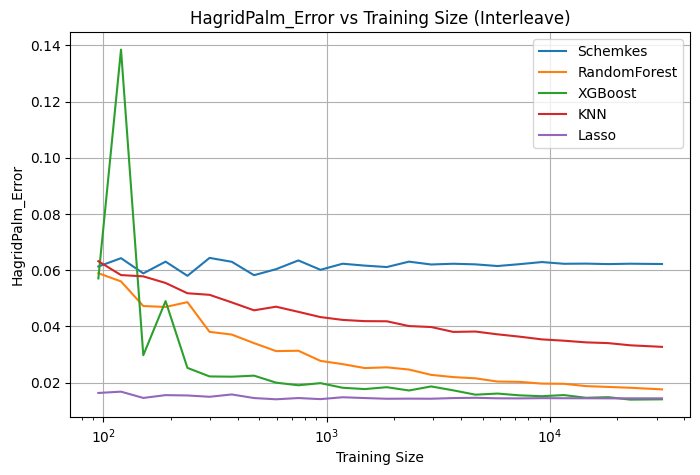

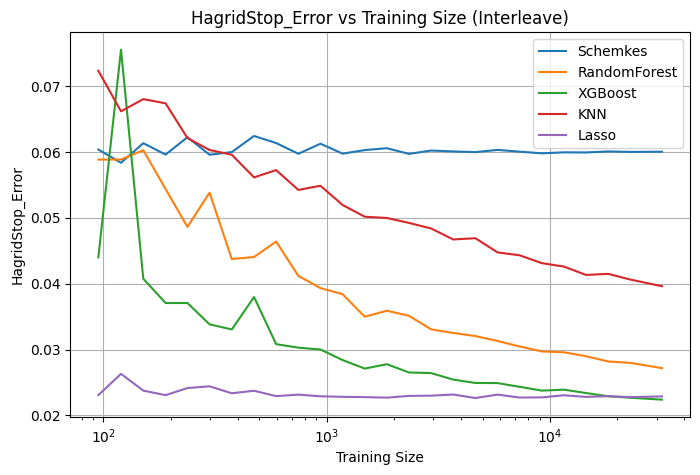

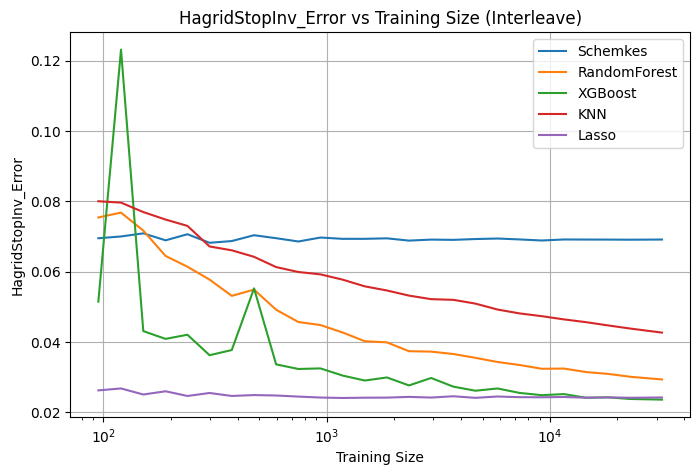

In [136]:
data = total_results
# As many as the length of metrics
x_values = sizes[:len(data['Schemkes']['R2'])]
metrics = list(data["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Interleave)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [137]:
total_results_first_n = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes, additional_test_sets=additional_tests, output_dir='output', subsample="first_n")

Iterations: 100%|██████████| 26/26 [06:22<00:00, 14.70s/it]


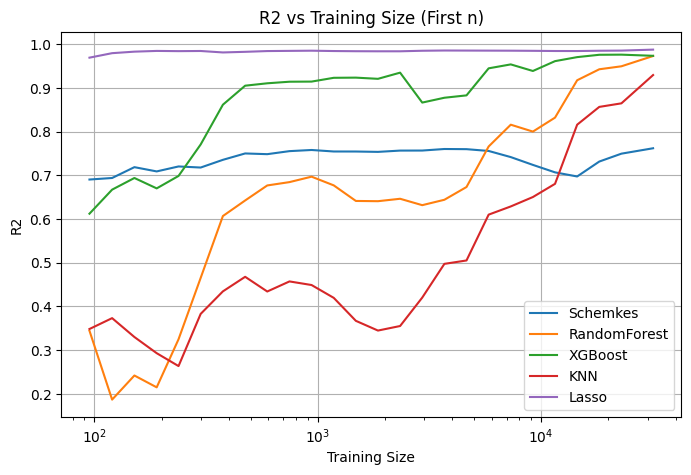

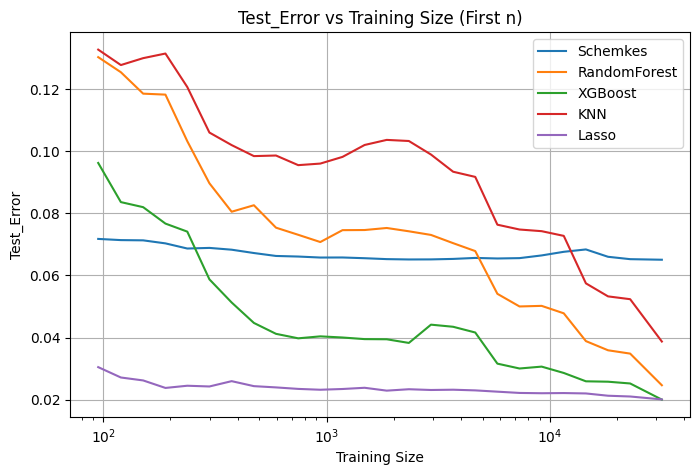

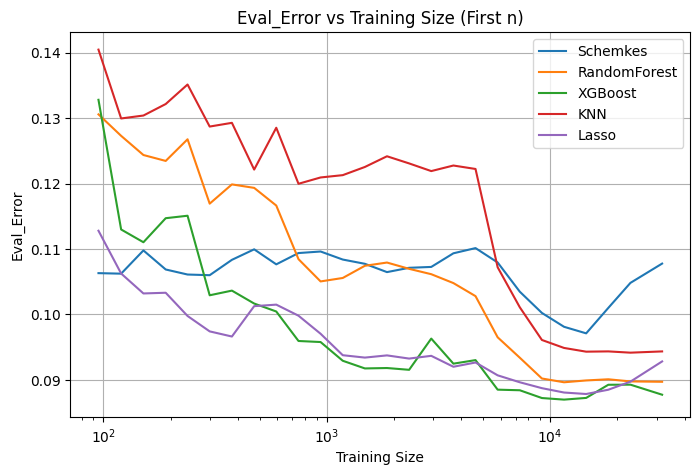

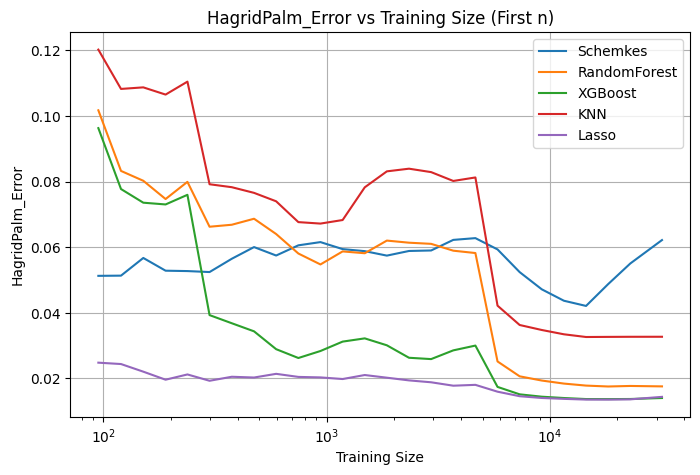

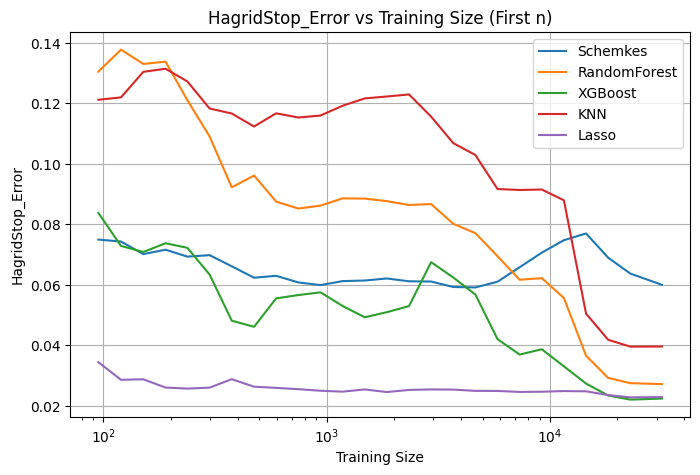

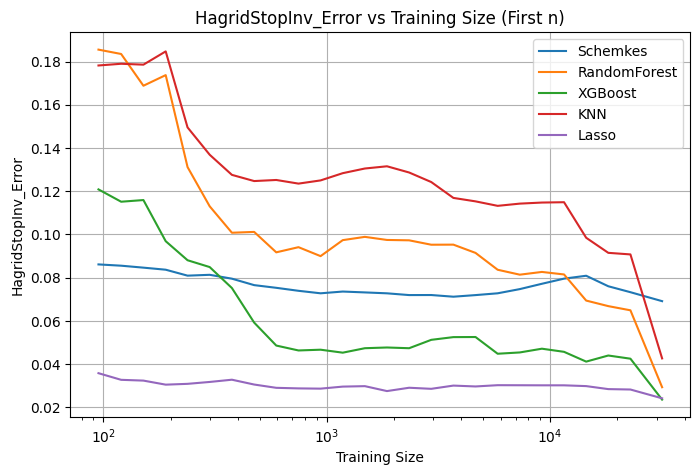

In [138]:
data_first_n = total_results_first_n

# As many as the length of metrics
x_values = sizes[:len(data_first_n['Schemkes']['R2'])]
metrics = list(data_first_n["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_first_n.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (First n)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [139]:
total_results_random = evaluation_pipeline(X_train=X_train, y_train=y_train, 
                                    X_test=X_test, y_test=y_test, 
                                    X_eval=X_custom_eval, y_eval=y_custom_eval, 
                                    models=tuned_models, model_names=tuned_models_names, 
                                    training_sizes=sizes, additional_test_sets=additional_tests ,output_dir='output', subsample="random")

Iterations: 100%|██████████| 26/26 [06:43<00:00, 15.54s/it]


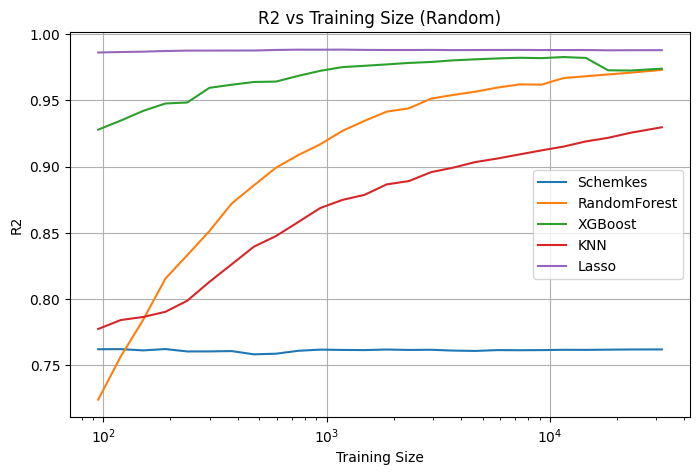

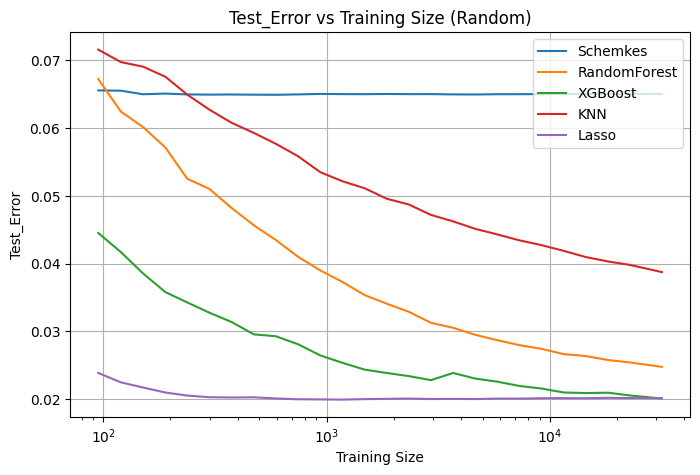

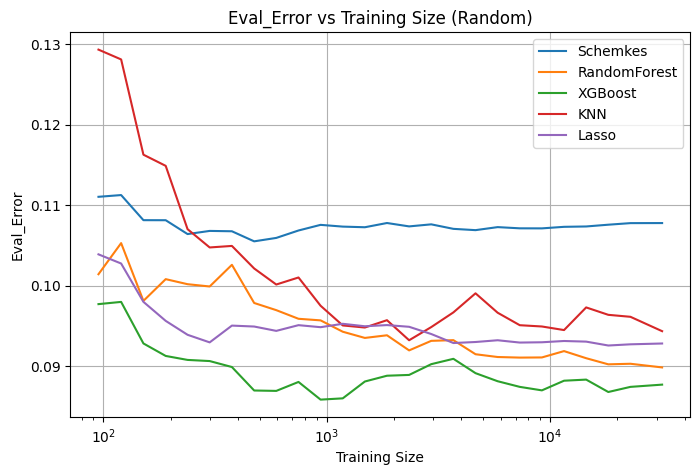

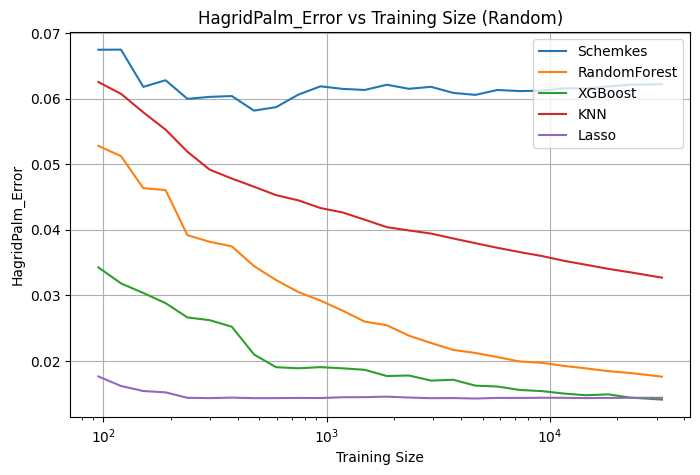

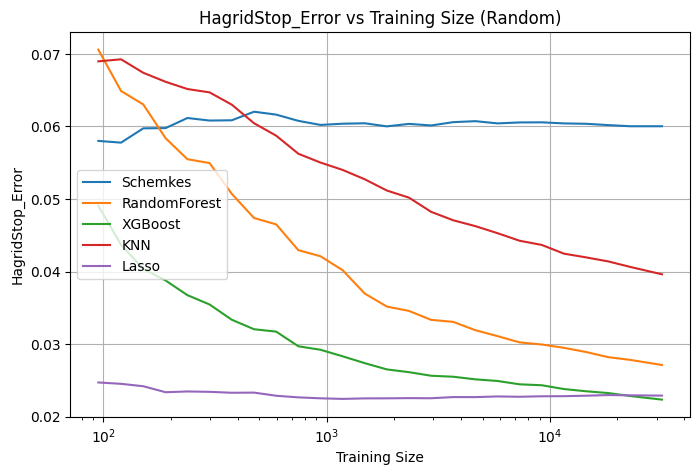

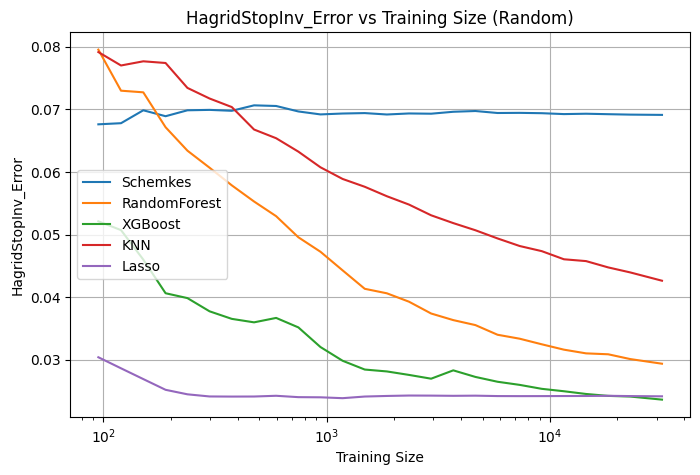

In [140]:
data_random = total_results_random

# As many as the length of metrics
x_values = sizes[:len(data_random['Schemkes']['R2'])]
metrics = list(data_random["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_random.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Random)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [141]:
print("FINISHED")

FINISHED


# INTERESTING RESULT FOR THE LASSO, LET'S EXAMINE!

[-0.03102343 -0.68851829]


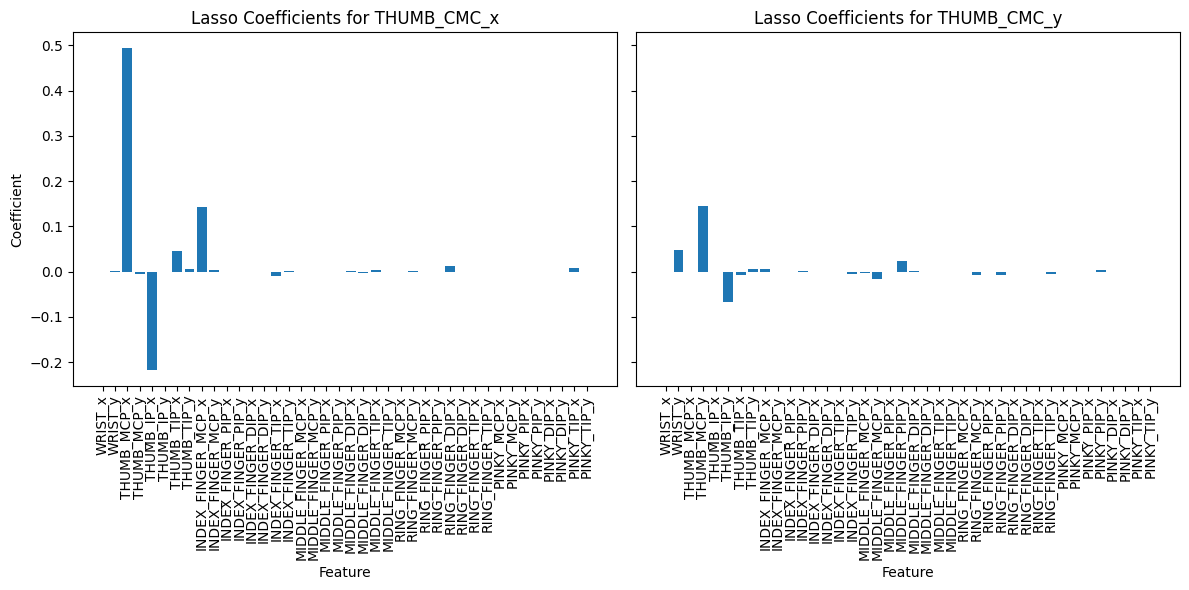

In [142]:
# Load 
best_lasso_model = None
with open("output/Lasso/Lasso_interleave_16447.pkl", "rb") as file:
    best_lasso_model = pickle.load(file)

print(best_lasso_model.named_steps['lasso'].intercept_)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot first bar chart
axes[0].bar(flattened_hand_keypoints_no_thumb_CMC, best_lasso_model.named_steps['lasso'].coef_[0])
axes[0].set_xticks(range(len(flattened_hand_keypoints_no_thumb_CMC)))
axes[0].set_xticklabels(flattened_hand_keypoints_no_thumb_CMC, rotation=90)
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Lasso Coefficients for THUMB_CMC_x')

# Plot second bar chart
axes[1].bar(flattened_hand_keypoints_no_thumb_CMC, best_lasso_model.named_steps['lasso'].coef_[1])
axes[1].set_xticks(range(len(flattened_hand_keypoints_no_thumb_CMC)))
axes[1].set_xticklabels(flattened_hand_keypoints_no_thumb_CMC, rotation=90)
axes[1].set_xlabel('Feature')
axes[1].set_title('Lasso Coefficients for THUMB_CMC_y')

# Adjust layout
plt.tight_layout()
plt.show()

# Let's attempt using our data to make it.

In [143]:
X_hypothenar = our_hands_total_normalized_df[flattened_keypoint_names + ['HYPOTHENAR_x', 'HYPOTHENAR_y']]
y_hypothenar = our_hands_total_normalized_df[['HYPOTHENAR_x', 'HYPOTHENAR_y']]
X_train_hypothenar, X_test_hypothenar, y_train_hypothenar, y_test_hypothenar = train_test_split(X_hypothenar, y_hypothenar, test_size=0.2, shuffle=False)
y_custom_eval_hypothenar = y_test_hypothenar
X_custom_eval_hypothenar = X_test_hypothenar

# Hyperparameter tune models
# Initialize Random Forest Regressor
rf_model_hypothernar = RandomForestRegressor(random_state=seed, n_jobs=njobs)
kf_hypo = KFold(n_splits=4, shuffle=True, random_state=seed)


# Define the hyperparameter search space
rf_param_space_hypothernar = {
    'n_estimators': Integer(50, 750),          # Number of trees
    'max_depth': Integer(5, 50),               # Depth of each tree
    'min_samples_split': Integer(2, 10),       # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),        # Minimum samples at a leaf node
    'max_features': Real(0.1, 1.0, prior='uniform')    # Features to consider
}

rf_opt_hypothenar = BayesSearchCV(
    estimator=rf_model_hypothernar,
    search_spaces=rf_param_space_hypothernar,
    n_iter=50,                 # Number of iterations for optimization
    cv=kf_hypo,                     # K-Fold Cross Validation
    scoring='r2',              # Metric to optimize
    random_state=seed,
    n_jobs=njobs                  # Use all available cores
)

if os.path.isfile('output_new/rf_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/rf_bayes_opt_hypothenar.pkl', 'rb') as f:
    rf_opt_hypothenar = pickle.load(f)
else:
  rf_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

print("Best Parameters:", rf_opt_hypothenar.best_params_)
print("Best Validation Score:", rf_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = rf_opt_hypothenar.best_estimator_.score(X_test_hypothenar, y_test_hypothenar)
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/rf_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/rf_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(rf_opt_hypothenar, file)
        print("Optimization results saved to 'rf_bayes_opt_hypothenar.pkl'.")

# Initialize XGBRegressor
xgb_model_hypothenar = XGBRegressor(random_state=seed, n_jobs=njobs)

# Define the hyperparameter search space

xgb_param_space_hypothenar = {
    'n_estimators': Integer(50, 750),             # Number of boosting rounds
    'max_depth': Integer(3, 20),                  # Maximum depth of trees
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),  # Learning rate
    'min_child_weight': Integer(1, 10),           # Minimum sum of instance weight
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Subsample ratio for columns
    'gamma': Real(0.0, 5.0, prior='uniform')      # Minimum loss reduction
}

# Initialize BayesSearchCV
xgb_opt_hypothenar = BayesSearchCV(
    estimator=xgb_model_hypothenar,
    search_spaces=xgb_param_space_hypothenar,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf_hypo,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

if os.path.isfile('output_new/xgb_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/xgb_bayes_opt_hypothenar.pkl', 'rb') as f:
    xgb_opt_hypothenar = pickle.load(f)
else:
  xgb_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

# Print best parameters and scores
print("Best Parameters:", xgb_opt_hypothenar.best_params_)
print("Best Validation Score:", xgb_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, xgb_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/xgb_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/xgb_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(xgb_opt_hypothenar, file)
        print("Optimization results saved to 'xgb_bayes_opt_hypothenar.pkl'.")

# Initialize k-NN Regressor
knn_model_hypothenar = KNeighborsRegressor(n_jobs=njobs)

# Define the hyperparameter search space

knn_param_space_hypothenar = {
    'n_neighbors': Integer(2, 75),               # Number of neighbors
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': Integer(1, 3)                           # Power parameter for Minkowski (if metric='minkowski')
}

# Initialize BayesSearchCV
knn_opt_hypothenar = BayesSearchCV(
    estimator=knn_model_hypothenar,
    search_spaces=knn_param_space_hypothenar,
    n_iter=50,                   # Number of iterations for optimization
    cv=kf_hypo,                       # Cross-validation strategy
    scoring='r2',                # Optimization metric
    random_state=seed,
    n_jobs=njobs
)

if os.path.isfile('output_new/knn_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/knn_bayes_opt_hypothenar.pkl', 'rb') as f:
    knn_opt_hypothenar = pickle.load(f)
else:
  knn_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

# Print best parameters and scores
print("Best Parameters:", knn_opt_hypothenar.best_params_)
print("Best Validation Score:", knn_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, knn_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/knn_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/knn_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(knn_opt_hypothenar, file)
        print("Optimization results saved to 'knn_bayes_opt_hypothenar.pkl'.")


# Initialize Lasso
lasso_model_hypothenar = Lasso(max_iter=10000, random_state=seed)

# Define pipeline for scaling (Lasso requires feature scaling)
pipeline_hypothenar = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', lasso_model_hypothenar)  # Lasso regression
])

# Define hyperparameter search space
param_space_hypothenar = {
    'lasso__alpha': Real(1e-4, 1.0, prior='log-uniform')  # Regularization strength
}

lasso_opt_hypothenar = BayesSearchCV(
    estimator=pipeline_hypothenar,
    search_spaces=param_space_hypothenar,
    n_iter=50,
    cv=kf_hypo,
    scoring='r2',
    random_state=42,
    n_jobs=njobs
)

if os.path.isfile('output_new/lasso_bayes_opt_hypothenar.pkl'):
  # load
  with open('output_new/lasso_bayes_opt_hypothenar.pkl', 'rb') as f:
    lasso_opt_hypothenar = pickle.load(f)
else:
  lasso_opt_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)

print("Best Parameters:", lasso_opt_hypothenar.best_params_)
print("Best Validation Score:", lasso_opt_hypothenar.best_score_)
# Evaluate on the test set
test_score = r2_score(y_test_hypothenar, lasso_opt_hypothenar.best_estimator_.predict(X_test_hypothenar))
print("Test Set Score:", test_score)

# Save
if not os.path.isfile('output_new/lasso_bayes_opt_hypothenar.pkl'):
    # Save the BayesSearchCV object using pickle
    with open("output_new/lasso_bayes_opt_hypothenar.pkl", "wb") as file:
        pickle.dump(lasso_opt_hypothenar, file)
        print("Optimization results saved to 'lasso_bayes_opt_hypothenar.pkl'.")


Best Parameters: OrderedDict({'max_depth': 50, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750})
Best Validation Score: 0.9052945031698838
Test Set Score: 0.9304568376720279
Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 17, 'min_child_weight': 1, 'n_estimators': 661, 'subsample': 0.5565124489551536})
Best Validation Score: 0.9844405353069305
Test Set Score: 0.9927172660827637
Best Parameters: OrderedDict({'metric': 'minkowski', 'n_neighbors': 5, 'p': 3, 'weights': 'distance'})
Best Validation Score: 0.844832976073939
Test Set Score: 0.8344827149356658
Best Parameters: OrderedDict({'lasso__alpha': 0.0001})
Best Validation Score: 0.9999990150043543
Test Set Score: 0.9999991504597323


In [144]:
schemkes_model_hypothenar = SchemkesInterpolationModel(train_columns=['WRIST', 'PINKY_MCP'], target_column='HYPOTHENAR')

tuned_models_hypothenar = [
    schemkes_model_hypothenar,
    rf_opt_hypothenar.best_estimator_,
    xgb_opt_hypothenar.best_estimator_,
    knn_opt_hypothenar.best_estimator_,
    lasso_opt_hypothenar.best_estimator_,
]

sizes_hypo = [p*len(X_train_hypothenar) for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]


total_results_hypo = evaluation_pipeline(X_train=X_train_hypothenar, y_train=y_train_hypothenar,
                                    X_test=X_test_hypothenar, y_test=y_test_hypothenar,
                                    X_eval=X_custom_eval_hypothenar, y_eval=y_custom_eval_hypothenar,
                                    models=tuned_models_hypothenar, model_names=tuned_models_names,
                                    training_sizes=sizes_hypo, additional_test_sets=None, output_dir='output_new', subsample='random')

Iterations: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


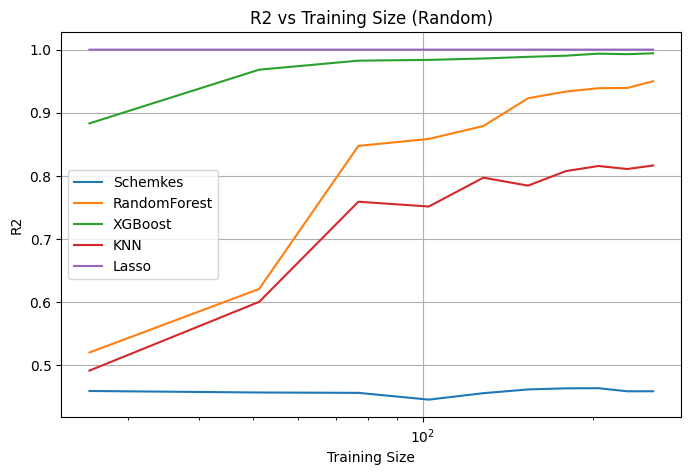

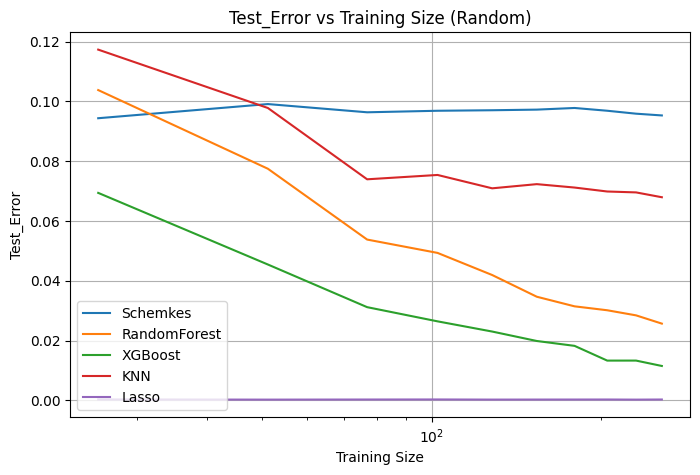

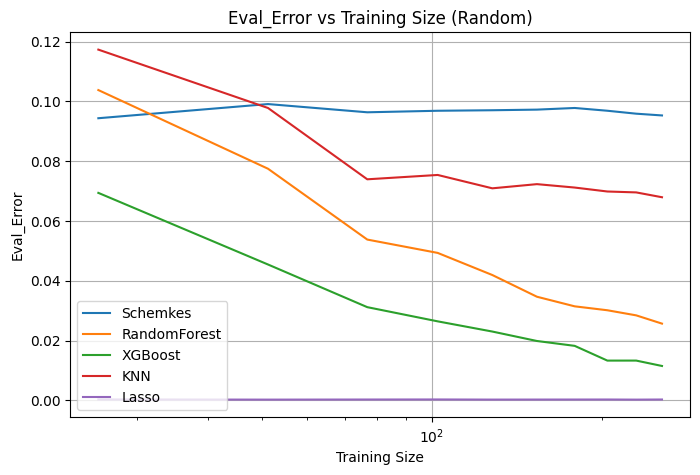

In [145]:
# Plot the results

data_hypo = total_results_hypo

# As many as the length of metrics
x_values = sizes_hypo[:len(data_hypo['Schemkes']['R2'])]
metrics = list(data_hypo["Schemkes"].keys())

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model, model_data in data_hypo.items():
        plt.plot(x_values, model_data[metric], label=model)

    plt.xlabel('Training Size')
    # x-axis is log
    plt.xscale('log')
    
    # Show the x-axis as integers
    plt.ylabel(metric)
    plt.title(f'{metric} vs Training Size (Random)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [146]:
def get_denormalized_predictions(original_df, predictions, target_keypoints_columns, hand_keypoints = None):
    """
    Denormalizes the predicted keypoints.

    Parameters:
        predictions (np.ndarray): Predicted keypoints.
        hand_keypoints (pd.DataFrame): Normalized hand keypoints.
        target_keypoints (list): Target keypoint names.

    Returns:
        pd.DataFrame: Denormalized predictions.
    """
    image_space_with_predictions_df = original_df.copy()
    image_space_with_predictions_df[target_keypoints_columns] = predictions
    if hand_keypoints is None:
        # Automatically extract hand keypoints from the original DataFrame
        hand_keypoints = process_strings(list(image_space_with_predictions_df.columns))
    image_space_with_predictions_df = transform_to_image_space(image_space_with_predictions_df, hand_keypoints)
    
    return image_space_with_predictions_df

In [147]:
schemkes_model_hypothenar.fit(X_train_hypothenar, y_train_hypothenar)
# xgb_opt_hypothenar.best_estimator_.fit(X_train_hypothenar, y_train_hypothenar)
temp_df = our_hands_total_normalized_df.copy()

schemkes_hypothenar_predictions = schemkes_model_hypothenar.predict(X_hypothenar)
# xgb_opt_hypotenar_predictions = xgb_opt_hypothenar.best_estimator_.predict(X_train_hypothenar)
# Get the same rows from temp_df as X_train_hypothenar
temp_df = temp_df.loc[X_hypothenar.index]
# Get the denormalized predictions
our_hands_total_with_hypothenar_predictions = get_denormalized_predictions(temp_df, 
                                                                          schemkes_hypothenar_predictions, 
                                                                          ['PRED_HYPOTHENAR_x', 'PRED_HYPOTHENAR_y'], 
                                                                          None)



71_IMG_4624.json


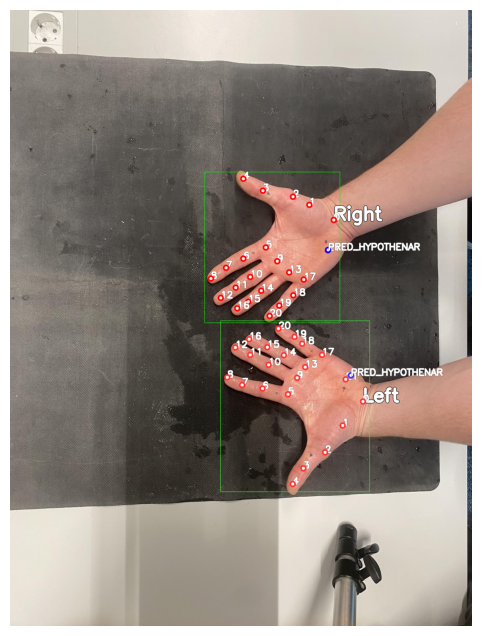

In [148]:
# Random filename for the output image
random_file_name = our_hands_total_with_hypothenar_predictions.iloc[random.randint(0, len(our_hands_total_with_hypothenar_predictions))]['FILE_NAME']
print(random_file_name)
attempt_to_draw_from_df(our_hands_total_with_hypothenar_predictions, 
                        random_file_name,
                        ['our_hands_dataset/FOLDER_FOR_DRAWING'],
                        list(hand_keypoints_names.values()) + ['HYPOTHENAR'],
                        ['PRED_HYPOTHENAR'], figsize=(8, 8))

In [149]:
# Plot lasso coefficients

best_lasso_hypothenar = lasso_opt_hypothenar.best_estimator_
lasso_opt_hypothenar.best_estimator_.fit(X_train_hypothenar, y_train_hypothenar)
flattened_hand_keypoints_hypothenar = [flkp for flkp in X_train_hypothenar.columns if flkp.endswith('_x') or flkp.endswith('_y')]
flattened_hand_keypoints_no_hypothenar = [flkp for flkp in flattened_hand_keypoints_hypothenar if 'HYPOTHENAR' not in flkp]

best_lasso_hypothenar.named_steps['lasso'].coef_.shape
X_train_hypothenar
# # Create subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# # Plot first bar chart
# axes[0].bar(flattened_hand_keypoints_no_hypothenar, best_lasso_hypothenar.named_steps['lasso'].coef_[0])
# axes[0].set_xticks(range(len(flattened_hand_keypoints_no_hypothenar)))
# axes[0].set_xticklabels(flattened_hand_keypoints_no_hypothenar, rotation=90)
# axes[0].set_xlabel('Feature')
# axes[0].set_ylabel('Coefficient')
# axes[0].set_title('Lasso Coefficients for HYPOTHENAR_x')

# # Plot second bar chart
# axes[1].bar(flattened_hand_keypoints_no_hypothenar, best_lasso_hypothenar.named_steps['lasso'].coef_[1])
# axes[1].set_xticks(range(len(flattened_hand_keypoints_no_hypothenar)))
# axes[1].set_xticklabels(flattened_hand_keypoints_no_hypothenar, rotation=90)
# axes[1].set_xlabel('Feature')
# axes[1].set_title('Lasso Coefficients for HYPOTHENAR_y')

# # Adjust layout
# plt.tight_layout()
# plt.show()


,WRIST_x,WRIST_y,THUMB_CMC_x,THUMB_CMC_y,THUMB_MCP_x,THUMB_MCP_y,THUMB_IP_x,THUMB_IP_y,THUMB_TIP_x,THUMB_TIP_y,...,PINKY_MCP_x,PINKY_MCP_y,PINKY_PIP_x,PINKY_PIP_y,PINKY_DIP_x,PINKY_DIP_y,PINKY_TIP_x,PINKY_TIP_y,HYPOTHENAR_x,HYPOTHENAR_y
0,0.247366,-0.876958,-0.146587,-0.800537,-0.483089,-0.473159,-0.713086,-0.203014,-0.935066,0.029004,...,0.692854,-0.000305,0.758322,0.212525,0.821117,0.438064,0.806802,0.581034,0.530233,-0.724587
1,-0.356959,-0.851494,-0.036261,-0.762151,0.350305,-0.513692,0.589497,-0.319036,0.902876,-0.128651,...,-0.762487,0.084632,-0.814717,0.320026,-0.803406,0.503846,-0.785775,0.648970,-0.662020,-0.671018
2,0.289825,-0.882653,-0.129466,-0.863536,-0.538188,-0.503547,-0.686149,-0.180147,-0.923537,0.081135,...,0.713181,-0.065121,0.755252,0.135500,0.865003,0.304384,0.858093,0.512672,0.589812,-0.692804
3,-0.339027,-0.888885,0.093454,-0.785272,0.543086,-0.419061,0.641900,-0.209745,0.914174,0.048177,...,-0.792362,-0.008184,-0.850832,0.139481,-0.856095,0.319633,-0.875195,0.548637,-0.597074,-0.668249
4,0.233564,-0.895973,-0.112178,-0.757037,-0.563662,-0.401795,-0.745641,-0.190380,-0.916334,0.083729,...,0.684453,-0.049033,0.792176,0.180972,0.812374,0.343390,0.876730,0.533431,0.529008,-0.728285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.222725,-0.887449,0.105217,-0.691535,0.458627,-0.391602,0.753922,-0.092189,0.924924,0.058537,...,-0.722357,-0.019427,-0.780669,0.327100,-0.799254,0.536136,-0.832982,0.631516,-0.615076,-0.521202
252,0.032298,-0.935427,-0.348328,-0.783460,-0.726134,-0.464015,-0.852808,-0.147845,-0.986234,0.147901,...,0.587266,-0.019625,0.675041,0.245886,0.721296,0.481171,0.749211,0.692764,0.439731,-0.561269
253,-0.295926,-0.882564,0.008682,-0.616009,0.394641,-0.341556,0.643280,-0.060686,0.924178,0.092046,...,-0.750897,0.022358,-0.795231,0.359588,-0.811713,0.527593,-0.838684,0.705035,-0.678712,-0.484097
254,0.007752,-0.935708,-0.374632,-0.780049,-0.697755,-0.542138,-0.845382,-0.184193,-0.948303,0.042086,...,0.488871,-0.124546,0.635166,0.156300,0.710216,0.402324,0.798488,0.550774,0.308523,-0.632646


Schemkes R-squared on Test Set: 0.7620746934037265
Schemkes R-squared on Custom Evaluation Set: -0.10955749129830311
60_IMG_4613.json


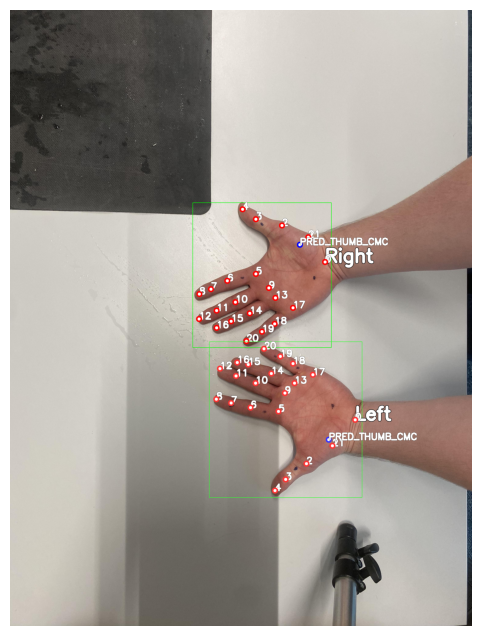

In [150]:
schemkes_model_normal = SchemkesInterpolationModel(train_columns=['WRIST', 'INDEX_FINGER_MCP'], target_column='THUMB_CMC')
schemkes_model_normal.fit(X_train, y_train)

# Schemkes on test set
schemkes_predictions = schemkes_model_normal.predict(X_test)
schemkes_r2 = r2_score(y_test, schemkes_predictions)

# Schemkes on custom evaluation set
schemkes_custom_predictions = schemkes_model_normal.predict(X_custom_eval)
schemkes_custom_r2 = r2_score(y_custom_eval, schemkes_custom_predictions)

print("Schemkes R-squared on Test Set:", schemkes_r2)
print("Schemkes R-squared on Custom Evaluation Set:", schemkes_custom_r2)

temp_df = our_hands_total_normalized_df.copy()
# Get the same rows from temp_df as X_custom_eval
temp_df = temp_df.loc[X_custom_eval.index]
# Get the denormalized predictions
our_hands_total_with_schemkes_predictions = get_denormalized_predictions(temp_df, 
                                                                          schemkes_custom_predictions, 
                                                                          ['PRED_THUMB_CMC_x', 'PRED_THUMB_CMC_y'], 
                                                                          None)

# Random filename for the output image
random_file_name = our_hands_total_with_schemkes_predictions.iloc[random.randint(0, len(our_hands_total_with_schemkes_predictions))]['FILE_NAME']
print(random_file_name)
attempt_to_draw_from_df(our_hands_total_with_schemkes_predictions, 
                        random_file_name,
                        ['our_hands_dataset/FOLDER_FOR_DRAWING'],
                        list(hand_keypoints_names.values()) + ['THUMB_CMC'],
                        ['PRED_THUMB_CMC'], figsize=(8, 8))

